# Project Title: Stock Reactivity to COVID-19 Trends
# Team Members:
Aryan Ringshia - aryanrr

Neil Mankodi - nmankodi

Part II:

In [1]:
# all imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from typing import List

In [2]:
# loading the data and converting the date column to datetime
merged_df = pd.read_csv('/kaggle/input/618-p2/merged_data.csv', index_col = 0)
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.head()

,Date,Natural_Gas_Price,Natural_Gas_Vol,Crude_oil_Price,Crude_oil_Vol,Copper_Price,Copper_Vol,Bitcoin_Price,Bitcoin_Vol,Platinum_Price,...,West Virginia,Wisconsin,Wyoming,Total Deaths,Northeast,Midwest,South,West,S&P_500_Price_Direction,Total Cases
0,2023-03-09,2.543,138150.0,75.72,349960.0,4.0390,54530.0,20361.8,468760.0,949.3,...,0.0,708.0,0.0,590.0,6645.0,24584.0,4538.0,10468.0,equal,46235.0
1,2023-03-08,2.551,132610.0,76.66,335930.0,4.0270,79040.0,21710.8,316510.0,940.6,...,0.0,674.0,0.0,730.0,10221.0,8534.0,36522.0,9187.0,up,64464.0
2,2023-03-07,2.687,149480.0,77.58,398240.0,3.9750,77400.0,22197.8,304750.0,936.3,...,0.0,782.0,226.0,335.0,3268.0,10972.0,9234.0,11801.0,down,35275.0
3,2023-03-06,2.572,246370.0,80.46,292350.0,4.0885,63750.0,22410.0,215310.0,978.6,...,0.0,1260.0,0.0,47.0,4939.0,1483.0,967.0,964.0,up,8353.0
4,2023-03-03,3.009,185070.0,79.68,374200.0,4.0670,74569.0,22354.4,344630.0,979.4,...,1706.0,710.0,0.0,507.0,2813.0,888.0,49780.0,4954.0,down,58435.0


In [3]:
merged_df.columns

Index(['Date', 'Natural_Gas_Price', 'Natural_Gas_Vol', 'Crude_oil_Price',
       'Crude_oil_Vol', 'Copper_Price', 'Copper_Vol', 'Bitcoin_Price',
       'Bitcoin_Vol', 'Platinum_Price',
       ...
       'West Virginia', 'Wisconsin', 'Wyoming', 'Total Deaths', 'Northeast',
       'Midwest', 'South', 'West', 'S&P_500_Price_Direction', 'Total Cases'],
      dtype='object', length=102)

In [4]:
merged_df.shape

(772, 102)

In [5]:
# Define mapping of stock price and volumes to sectors

stock_to_sector_mapping = {
    'Tech': ['Apple_Vol', 'Microsoft_Vol', 'Nvidia_Vol', 'Google_Vol', 'Netflix_Vol', 'Amazon_Vol', 'Meta_Vol'],
    'Fossil_Fuels': ['Natural_Gas_Vol', 'Crude_oil_Vol'],
    'Metals': ['Copper_Vol', 'Silver_Vol', 'Gold_Vol'],
    'Cryptocurrency': ['Bitcoin_Vol', 'Ethereum_Vol'],
    'Transportation': ['Tesla_Vol']
}

stockprice_to_sector_mapping = {
    'Tech': ['Apple_Price', 'Microsoft_Price', 'Nvidia_Price', 'Google_Price', 'Netflix_Price', 'Amazon_Price', 'Meta_Price'],
    'Fossil_Fuels': ['Natural_Gas_Price', 'Crude_oil_Price'],
    'Metals': ['Copper_Price', 'Silver_Price', 'Gold_Price', 'Platinum_Price'],
    'Cryptocurrency': ['Bitcoin_Price', 'Ethereum_Price'],
    'Transportation': ['Tesla_Price']
}

# Descriptive Analysis

## Question 1 - 
How did the stock prices of major tech companies (e.g., Apple, Amazon, Netflix, Meta) respond to significant peaks in daily confirmed COVID-19 cases? We aim to identify patterns in market movements during high infection rates and assess sector reactivity.

In [6]:
def calculate_descriptive_stats(df, columns):
    """
    Calculate descriptive statistics for specified columns in the DataFrame.

    Parameters:
    - df: DataFrame containing the data
    - columns: List of column names for which descriptive statistics are required

    Returns:
    - DataFrame containing the descriptive statistics for specified columns
    """

    # Create an empty dictionary to store results
    stats_dict = {'Feature': [], 'Mean': [], 'Median': [], 'Range': [], 'Variance': [], 'Standard Deviation': []}

    # Iterate through each specified column
    for column in columns:
        # Skip non-numeric columns
        if df[column].dtype not in ['int64', 'float64']:
            continue

        # Calculate statistics for numeric columns
        mean = round(df[column].mean())
        median = round(df[column].median())
        data_range =round(df[column].max() - df[column].min())
        variance = round(df[column].var())
        std_dev = round(df[column].std())

        # Append statistics to the dictionary
        stats_dict['Feature'].append(column)
        stats_dict['Mean'].append(mean)
        stats_dict['Median'].append(median)
        stats_dict['Range'].append(data_range)
        stats_dict['Variance'].append(variance)
        stats_dict['Standard Deviation'].append(std_dev)

    # Create a DataFrame from the dictionary
    stats_df = pd.DataFrame(stats_dict)

    # Transpose DataFrame and set columns
    stats_df = stats_df.T
    stats_df.columns = stats_df.iloc[0]
    stats_df = stats_df[1:]

    return stats_df

In [7]:
# Analyse tech companies
columns_to_analyze = stockprice_to_sector_mapping['Tech']

# Calculate descriptive statistics
calculate_descriptive_stats(merged_df, columns_to_analyze)

Feature,Apple_Price,Microsoft_Price,Nvidia_Price,Google_Price,Netflix_Price,Amazon_Price,Meta_Price
Mean,132,247,164,104,426,140,241
Median,137,247,153,103,462,153,239
Range,126,208,285,97,525,105,293
Variance,864,2064,3833,662,17552,832,5542
Standard Deviation,29,45,62,26,132,29,74


### Interpretation:

Based on these descriptive statistics, we can observe that the stock prices of companies like Netflix and Meta, which offer digital services highly relevant during the pandemic (streaming, social media), show higher variability compared to others like Apple and Amazon. This indicates that there might be a stronger market reaction to significant peaks in daily confirmed COVID-19 cases, especially for companies heavily reliant on digital services. Further analysis, such as correlation studies between stock prices and daily confirmed cases, would provide more insight into the relationship between market movements and infection rates.

## Question 2 - 
Did fluctuations in economic indicators, such as the S&P 500 index, align with the severity of COVID-19 outbreaks, and were certain industries more resilient during the pandemic? We seek to the identify sectors that we more resilient.

In [8]:
# Initialize empty dictionaries to store aggregated data
sector_price_avg = {}
sector_vol_avg = {}

# Aggregate price data
for sector, stocks in stockprice_to_sector_mapping.items():
    sector_price_avg[sector + '_Price'] = merged_df[stocks].mean(axis=1)

# Aggregate volume data
for sector, stocks in stock_to_sector_mapping.items():
    sector_vol_avg[sector + '_Vol'] = merged_df[stocks].mean(axis=1)

# Create a new DataFrame with aggregated data
agg_data = pd.DataFrame({'Date': merged_df['Date']})

sector_price_df = pd.DataFrame(sector_price_avg)
sector_vol_df = pd.DataFrame(sector_vol_avg)

sector_aggregate = pd.concat([merged_df['Date'], sector_price_df, sector_vol_df], axis=1)
sector_aggregate['S&P_500_Price'] = merged_df['S&P_500_Price']

In [9]:
# Define columns to analyze based on stock price mapping and include S&P 500 price
columns_to_analyze = [key + '_Price' for key in stockprice_to_sector_mapping.keys()] + ['S&P_500_Price']

# Calculate descriptive statistics
calculate_descriptive_stats(sector_aggregate, columns_to_analyze)

Feature,Tech_Price,Fossil_Fuels_Price,Metals_Price,Cryptocurrency_Price,Transportation_Price,S&P_500_Price
Mean,208,36,703,15285,207,3880
Median,208,37,708,12384,221,3951
Range,195,59,284,33701,386,2559
Variance,1940,169,1980,79163231,8459,288111
Standard Deviation,44,13,44,8897,92,537


### Interpretation:
Based on these descriptive statistics, it appears that certain industries were more resilient than others during the COVID-19 pandemic. Industries like the tech and transportation sectors experienced moderate variability in prices, indicating potential resilience amidst economic disruptions. Conversely, industries like cryptocurrencies and metals showed higher variability, suggesting greater sensitivity to market dynamics during the pandemic.

## Question 3 - 
How did COVID-19 case counts in specific regions of the USA, for instance in the East and MidWest, affect the stock market the most? This question delves into regional variations in COVID-19 case counts and their corresponding impact. We aim to identify which regions exerted the most significant influence on market reactivity.

In [10]:
# Define columns to analyze
columns_to_analyze = ['Total Cases', 'Total Deaths', 'Northeast', 'Midwest', 'South', 'West']

# Calculate descriptive statistics
calculate_descriptive_stats(merged_df, columns_to_analyze)

Feature,Total Cases,Total Deaths,Northeast,Midwest,South,West
Mean,105620,1189,17470,22884,41523,23743
Median,67330,905,12892,15110,24408,14542
Range,1340950,4375,242260,298485,561451,295855
Variance,18069289819,930111,614061797,902912098,3023202957,1135314080
Standard Deviation,134422,964,24780,30048,54984,33694


### Interpretation:

- Total Cases: High variance and large range indicates that there is a wide variation in number of daily cases.
- Total Deaths: The average number of deaths is relatively low compared to total cases, indicating a relatively low mortality rate compared to the infection rate.
- The standard deviation for total cases is quite high, indicating considerable variability in infection rates across the dataset.
- The descriptive statistics suggest that COVID-19 case counts in specific regions, particularly the South and Midwest, may have a more pronounced effect on market reactivity due to higher average case counts and greater variability.
- The mean and median total cases and total deaths are higher in the South compared to the Northeast and Midwest which indicates that the South was affected more by COVID.
- The South also has the highest range, variance, and standard deviation in total cases and total deaths, indicating greater variability in the number of cases and deaths within the region. Northeast has the lowest variability among the regions

## Question 4 - 
Is there a correlation between cryptocurrency, gold and silver stock price volatility and daily confirmed COVID-19 cases?

In [11]:
# Define columns to analyze
columns_to_analyze = stockprice_to_sector_mapping['Cryptocurrency'] + stockprice_to_sector_mapping['Metals']

# Calculate descriptive statistics
calculate_descriptive_stats(merged_df, columns_to_analyze)

Feature,Bitcoin_Price,Ethereum_Price,Copper_Price,Silver_Price,Gold_Price,Platinum_Price
Mean,28859,1711,4,23,1803,983
Median,23233,1571,4,23,1806,975
Range,62702,4700,3,18,592,702
Variance,278519018,1517340,1,12,9373,14192
Standard Deviation,16689,1232,1,3,97,119


### Interpretation:

Based on the descriptive statistics, we can make some preliminary observations:
- Cryptocurrency prices (Bitcoin and Ethereum) exhibit high variability, with large ranges and standard deviations, indicating significant volatility.
- Precious metals prices (Gold, Silver, and Platinum) show comparatively lower variability, with narrower ranges and smaller standard deviations.
- Copper price shows very low variability, with a small range and standard deviation.

We can infer that cryptocurrency prices, characterized by their high volatility, might show a stronger correlation with fluctuations in daily confirmed COVID-19 cases compared to precious metals like gold, silver, and platinum. Further analysis, particularly correlation analysis, would provide more insight into the specific relationships between these asset prices and COVID-19 dynamics.

# Visualizations Analysis

## Question 1 - 
How did the stock prices of major tech companies (e.g., Apple, Amazon, Netflix, Meta) respond to significant peaks in daily confirmed COVID-19 cases? We aim to identify patterns in market movements during high infection rates and assess sector reactivity.

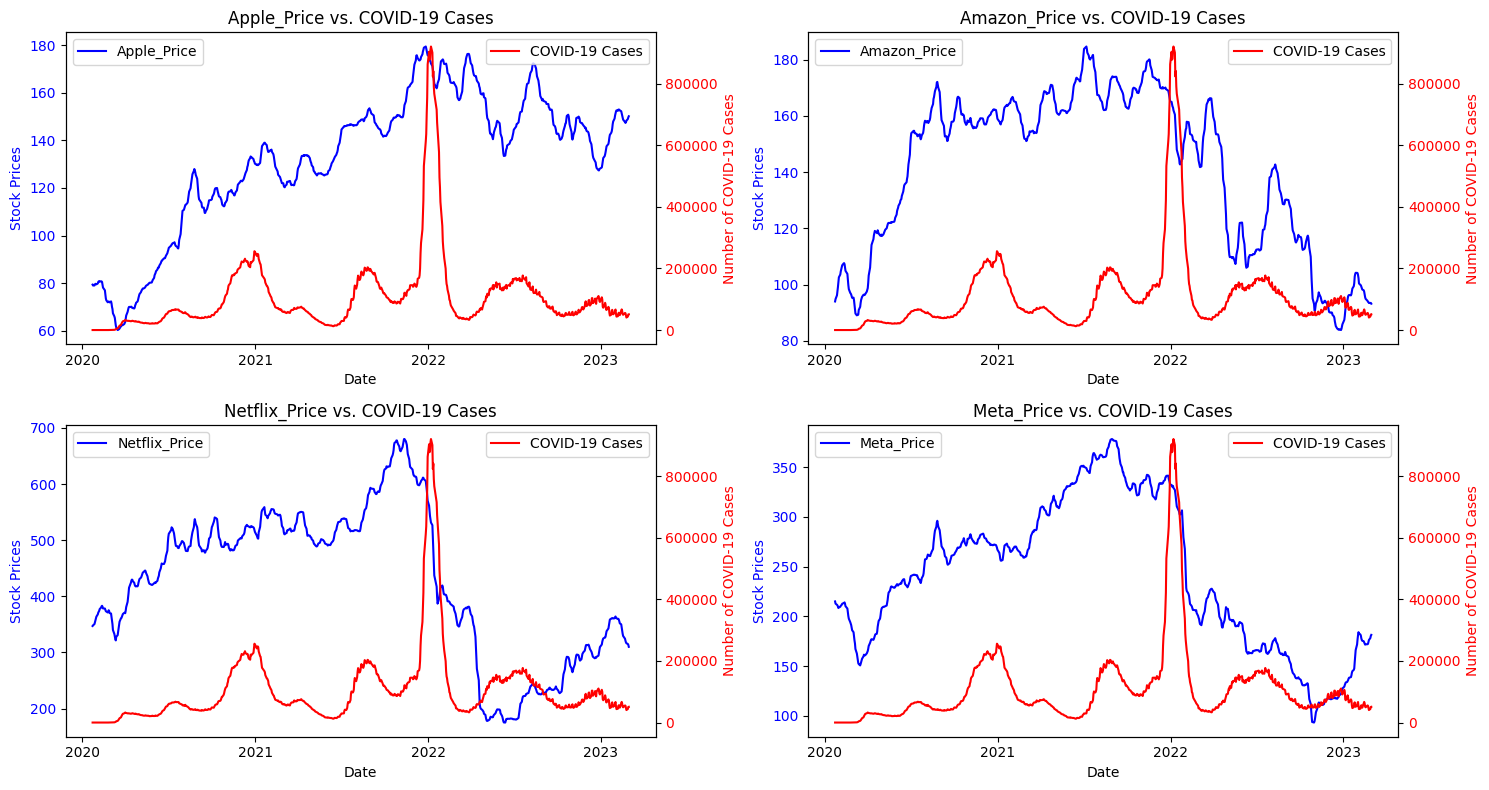

In [12]:
tech_stock_columns = ['Apple_Price', 'Amazon_Price', 'Netflix_Price', 'Meta_Price'] # defining the tech stock columns
covid_cases_column = 'Total Cases' # defining the COVID-19 cases column

fig, axs = plt.subplots(2, 2, figsize=(15, 8)) # creating a 2x2 grid of subplots

axs = axs.flatten() # flattening the 2x2 grid into a 1x4 grid for easier iteration

for i, tech_stock in enumerate(tech_stock_columns): # iterating through the tech stock columns
    smoothed_prices = merged_df[tech_stock].rolling(window=7).mean() # smoothing the stock prices
    # plotting the smoothed stock prices
    axs[i].plot(merged_df['Date'], smoothed_prices, label=f'{tech_stock}', color='blue')

    axs[i].set_xlabel('Date') # setting the x-axis label
    axs[i].set_ylabel('Stock Prices', color='blue') # setting the y-axis label
    axs[i].tick_params(axis='y', labelcolor='blue') # setting the y-axis color
    axs[i].legend(loc='upper left') # setting the legend location
    
    ax2 = axs[i].twinx() # creating a second y-axis
    smoothed_cases = merged_df[covid_cases_column].rolling(window=7).mean() # smoothing the COVID-19 cases
    ax2.plot(merged_df['Date'], smoothed_cases, label='COVID-19 Cases', color='red') # plotting the smoothed COVID-19 cases
    
    ax2.set_ylabel('Number of COVID-19 Cases', color='red') # setting the second y-axis label
    ax2.tick_params(axis='y', labelcolor='red') # setting the second y-axis color
    ax2.legend(loc='upper right') # setting the second legend location
    
    axs[i].set_title(f'{tech_stock} vs. COVID-19 Cases') # setting the title
    
    axs[i].xaxis.set_major_locator(mdates.YearLocator()) # setting the x-axis major locator
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # setting the x-axis major formatter
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=0) # rotating the x-axis labels
    
plt.tight_layout() # tightening the layout
plt.show() # displaying the plot

### Interpretation:
In this visualization we try to visually ascertain if the tech companies' stock prices had any relation / interaction with peaks and dips in the total covid cases. The observations shown below confirm that our Question 1 is on the right track with potentially interesting findings possible:
1. Apple and Meta Stock Prices Increase with COVID Cases:
    1. Both Apple and Meta are technology companies with diversified portfolios, including hardware, software, and online services.
    2. During the pandemic, the demand for personal computing devices, streaming services, and online communication tools surged as remote work and digital connectivity became essential. Apple's product line, including iPhones, MacBooks, and iPads, likely saw increased sales due to the growing importance of personal technology in daily life.
    3. Meta, being the parent company of platforms like Facebook and Instagram, could have experienced higher user engagement as people turned to social media for connectivity and entertainment.
2. Netflix and Amazon Stock Prices Dip during COVID Case Peaks:
    1. Netflix and Amazon both rely on intricate logistics and content production processes, which were disrupted during the pandemic.
    2. Production halts, delayed releases, and operational challenges in content creation, such as social distancing measures on film sets may have impacted Netflix's subscriber growth and retention.
    3. Supply chain disruptions likely strained Amazon's logistics and distribution capabilities affecting revenue and investor confidence.
3. Additionally, we observe that Apple seems to show a continued overall increasing trend in it's stock price whereas Amazon, Netflix and Meta show a sharp drop with some increasing trends in recent times when the pandemic has nearly ended. This speaks to Apple's excellent resilience to the Covid-19 pandemic.
4. The grouping here is merely based on this visualization. Whether or not this grouping is actually true can be concluded from performing the ANOVA and Tukey's HSD analysis. This will guide our analysis in the inferential stage of this project.

## Question 2
Did fluctuations in economic indicators, such as the S&P 500 index, align with the severity of COVID-19 outbreaks, and were certain industries more resilient during the pandemic? We seek to the identify sectors that we more resilient.

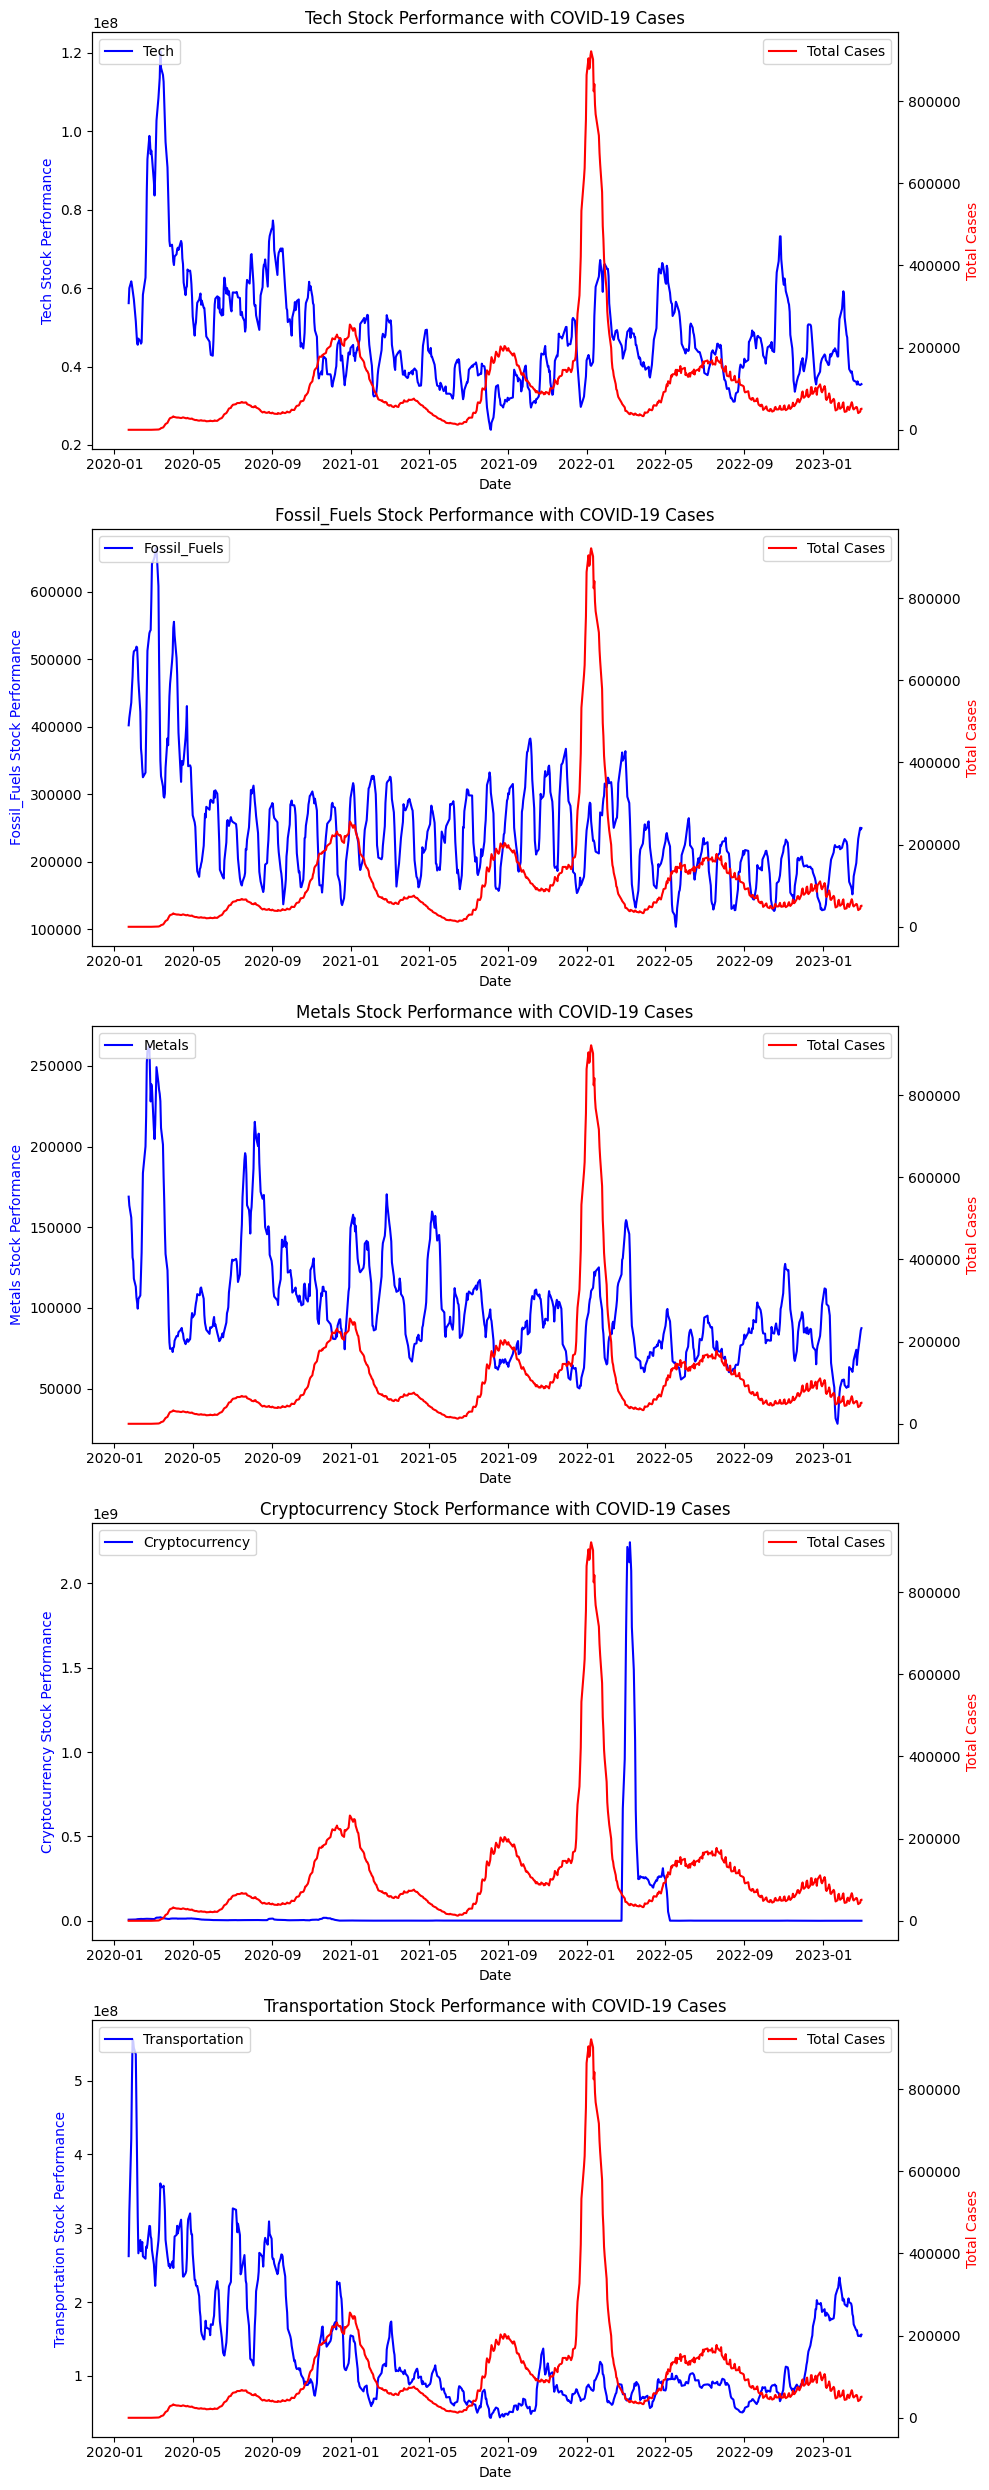

In [13]:
stock_to_sector_mapping = {
    'Tech': ['Apple_Vol', 'Microsoft_Vol', 'Nvidia_Vol', 'Google_Vol', 'Netflix_Vol', 'Amazon_Vol', 'Meta_Vol'],
    'Fossil_Fuels': ['Natural_Gas_Vol', 'Crude_oil_Vol'],
    'Metals': ['Copper_Vol', 'Silver_Vol', 'Gold_Vol'],
    'Cryptocurrency': ['Bitcoin_Vol', 'Ethereum_Vol'],
    'Transportation': ['Tesla_Vol']
} # defining the stock to sector mapping

# creating a new dataframe to store the aggregated sector data
aggregated_sector_data = pd.DataFrame(columns=['Date', 'Total Cases'] + list(stock_to_sector_mapping.keys()))

for sector, stocks in stock_to_sector_mapping.items(): # iterating through the stock to sector mapping
    # creating a new dataframe to store the sector data
    sector_data = merged_df[['Date', 'Total Cases'] + stocks]
    aggregated_sector_data[sector] = sector_data[stocks].mean(axis=1) # aggregating the sector data
    
aggregated_sector_data['Total Cases'] = merged_df['Total Cases'] # adding the COVID-19 cases to the aggregated sector data
aggregated_sector_data['Date'] = merged_df['Date'] # adding the date to the aggregated sector data

fig, axs = plt.subplots(len(stock_to_sector_mapping), 1, figsize=(10, 5*len(stock_to_sector_mapping))) # creating a grid of subplots

for i, (sector, stocks) in enumerate(stock_to_sector_mapping.items()): # iterating through the stock to sector mapping
    ax1 = axs[i] # getting the current axis
    ax2 = ax1.twinx() # creating a second y-axis

    smoothed_sector = aggregated_sector_data[sector].rolling(window=7).mean() # smoothing the sector data
    ax1.plot(aggregated_sector_data['Date'], smoothed_sector, label=sector, color='blue') # plotting the smoothed sector data
    
    smoothed_cases = aggregated_sector_data['Total Cases'].rolling(window=7).mean() # smoothing the COVID-19 cases
    ax2.plot(aggregated_sector_data['Date'], smoothed_cases, label='Total Cases', color='red') # plotting the smoothed COVID-19 cases

    ax1.set_xlabel('Date') # setting the x-axis label
    ax1.set_ylabel(f'{sector} Stock Performance', color='blue') # setting the y-axis label
    ax2.set_ylabel('Total Cases', color='red') # setting the second y-axis label
    ax1.legend(loc='upper left') # setting the legend location
    ax2.legend(loc='upper right') # setting the second legend location
    ax1.set_title(f'{sector} Stock Performance with COVID-19 Cases') # setting the title

plt.tight_layout() # tightening the layout
plt.show() # displaying the plot

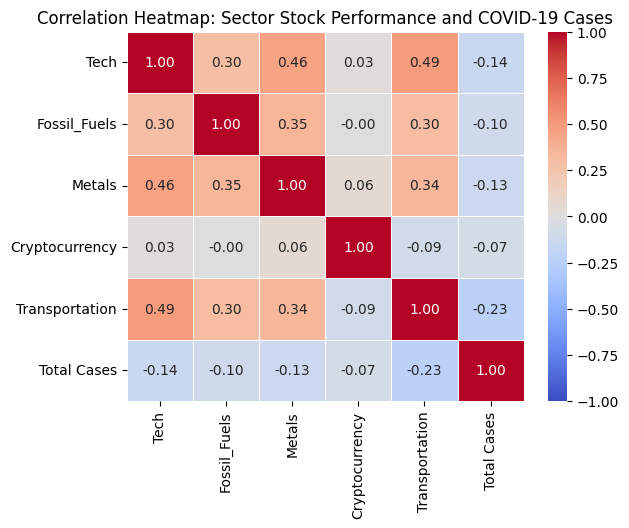

In [14]:
# creating a new dataframe to store the data needed for the correlation matrix
correlation_data = aggregated_sector_data[list(stock_to_sector_mapping.keys()) + ['Total Cases']]
correlation_matrix = correlation_data.corr() # creating the correlation matrix
plt.figure() # creating a new figure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmax=1, vmin=-1) # creating the heatmap
plt.title('Correlation Heatmap: Sector Stock Performance and COVID-19 Cases') # setting the title
plt.show() # displaying the plot

### Interpretation:
In this section we try and understand which sectors are more resilient to fluctuations in the covid cases. Our observations are as follows:
1. From the line plots and heatmap we can observe that the total count of covid cases has a generally negative impact on the average stock performance of all sectors. This is expected and is in line with our thinking behind this research question.
2. We can further use the correlation values to try and make conclusions on how resilient each sector is. The idea is that the closer to zero is the correlation, more resilient is that sector. This obviously may not be true since we cannot assume that correlation implies causation but given that we do not have control over the environment in which these changes occur, the current set-up will have to suffice. We can see that the order of resilience from most to least is as follows: Cryptocurrency > Fossil Fuels > Metals > Tech > Transportation. This could in theory be used as a guidance for how investment decisions can be made in terms of which sectors are safer to invest.

## Question 3 - 
How did COVID-19 case counts in specific regions of the USA, for instance in the East and MidWest, affect the stock market the most? This question delves into regional variations in COVID-19 case counts and their corresponding impact. We aim to identify which regions exerted the most significant influence on market reactivity.

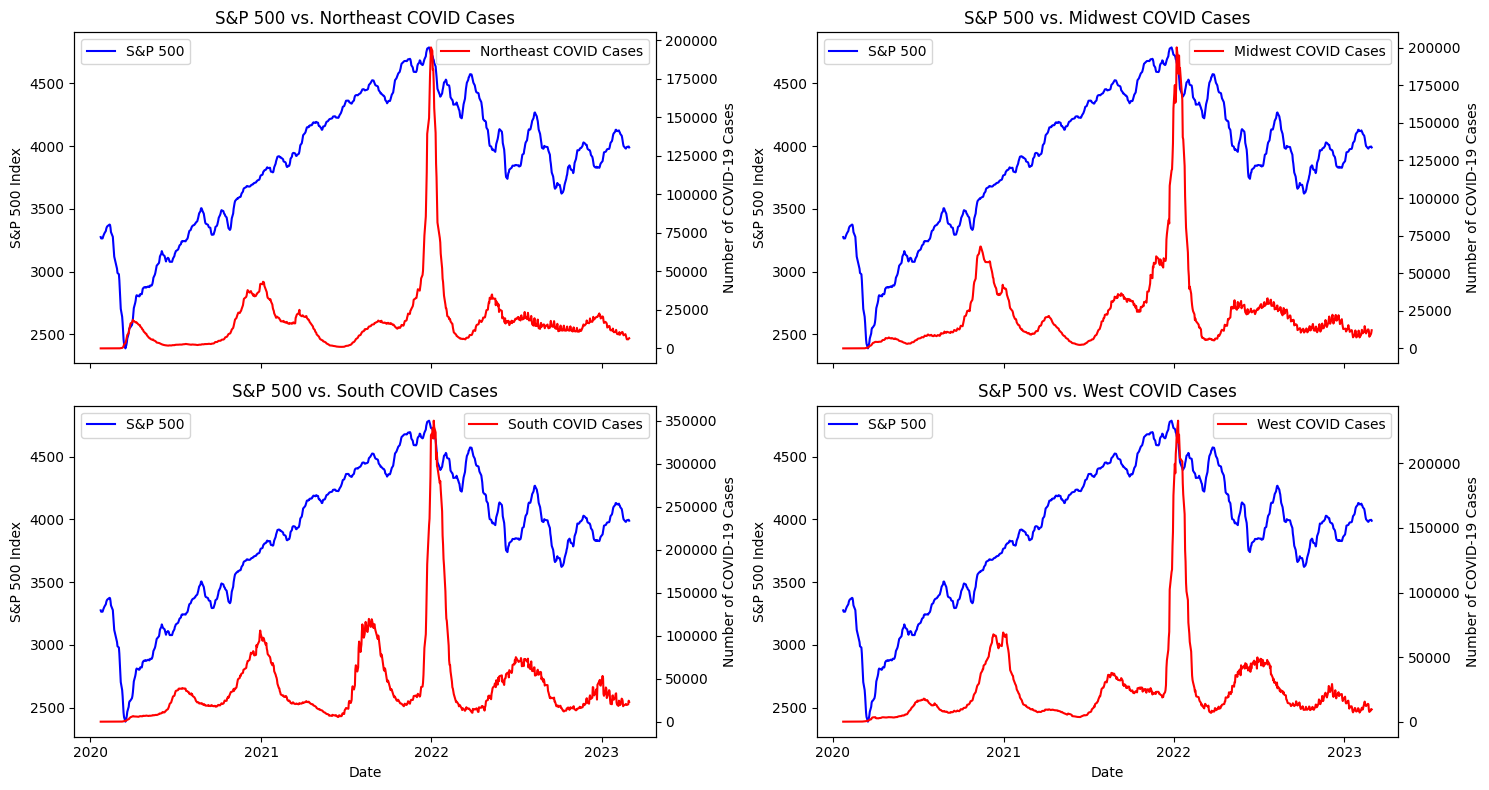

In [15]:
sp500_column = 'S&P_500_Price' # defining the S&P 500 column
zones_covid_cases = ['Northeast', 'Midwest', 'South', 'West'] # defining the zones COVID-19 cases columns

fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True) # creating a 2x2 grid of subplots
axs = axs.flatten() # flattening the 2x2 grid into a 1x4 grid for easier iteration

axs[0].xaxis.set_major_locator(mdates.YearLocator()) # setting the x-axis major locator
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # setting the x-axis major formatter
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=0) # rotating the x-axis labels

for i, zone in enumerate(zones_covid_cases): # iterating through the zones COVID-19 cases columns
    smoothed_sp500 = merged_df[sp500_column].rolling(window=7).mean() # smoothing the S&P 500
    sns.lineplot(x='Date', y=smoothed_sp500, data=merged_df, ax=axs[i], label='S&P 500', color='blue') # plotting the smoothed S&P 500
    
    ax2 = axs[i].twinx() # creating a second y-axis
    smoothed_cases = merged_df[zone].rolling(window=7).mean() # smoothing the COVID-19 cases
    # plotting the smoothed COVID-19 cases
    sns.lineplot(x='Date', y=smoothed_cases, data=merged_df, ax=ax2, label=f'{zone} COVID Cases', color='red')
    
    axs[i].set_xlabel('Date') # setting the x-axis label
    axs[i].set_ylabel('S&P 500 Index') # setting the y-axis label
    ax2.set_ylabel('Number of COVID-19 Cases') # setting the second y-axis label
    axs[i].legend(loc='upper left') # setting the legend location
    axs[i].set_title(f'S&P 500 vs. {zone} COVID Cases') # setting the title

    
plt.tight_layout() # tightening the layout
plt.show() # displaying the plot

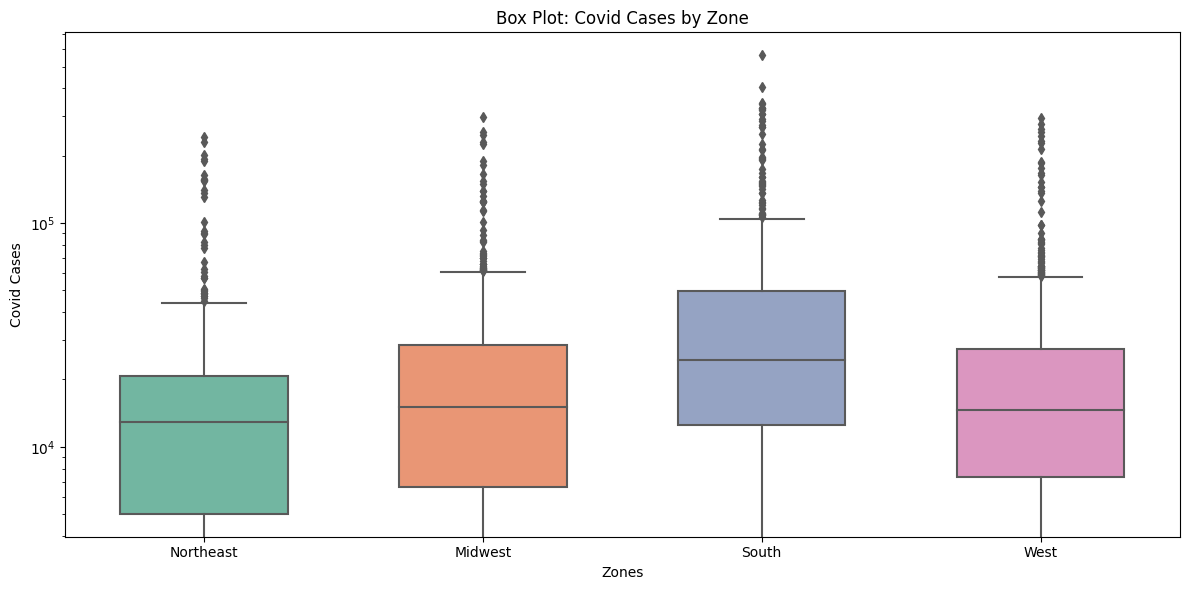

In [16]:
fig, ax = plt.subplots(figsize=(12, 6)) # creating a new figure
ax.set_yscale('log') # setting the y-axis scale to logarithmic due to scale differences
sns.boxplot(data=merged_df[zones_covid_cases], ax=ax, palette='Set2', width=0.6) # creating the box plot
ax.set_xlabel('Zones') # setting the x-axis label
ax.set_ylabel('Covid Cases') # setting the y-axis label
ax.set_title('Box Plot: Covid Cases by Zone') # setting the title
plt.tight_layout() # tightening the layout
plt.show() # displaying the plot

### Interpretation:
In these visualizations we try to ascertain if different zones in the United States had different impacts on the S&P 500 stock price index. Our observations are as follows:
1. From the line plots we can see that the S&P 500 was for the most part resillient to the rises and dips in the covid cases for each zone. The S&P 500 seems to show a steady upward trend with some very minor fluctuations which are in line with fluctuations in the covid cases. This speaks to the overall resillience of the market.
2. We can see that there are some differences in the fluctuations and trends in total covid cases across the four zones. This is interesting because we can now analyse if these changes are significant or not. This analysis will tell us if having different variables for the zone actually makes sense or not.
3. In the box plots we can see that there may be differences across the zones with south being the most different. It is important to note that the box plot only tells us if there might be some differences, the true conclusion is only possible from performing a ANOVA and Tukey's HSD analysis. This guides our analysis in the inferential stage of this project.

## Question 4 - 
Is there a correlation between cryptocurrency, gold and silver stock price volatility and daily confirmed COVID-19 cases?

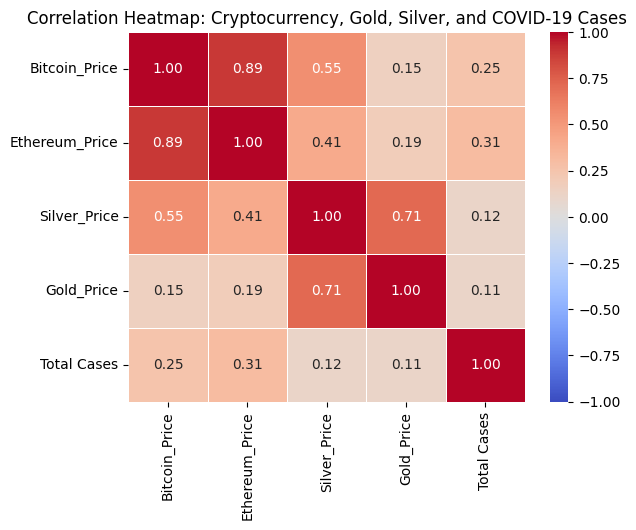

In [17]:
# defining the columns being considered for the correlation matrix
selected_columns_q4 = ['Bitcoin_Price', 'Ethereum_Price', 'Silver_Price', 'Gold_Price', 'Total Cases']
correlation_matrix = merged_df[selected_columns_q4].corr() # creating the correlation matrix

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmax=1,vmin=-1) # creating the heatmap
plt.title('Correlation Heatmap: Cryptocurrency, Gold, Silver, and COVID-19 Cases') # setting the title
plt.show() # displaying the plot

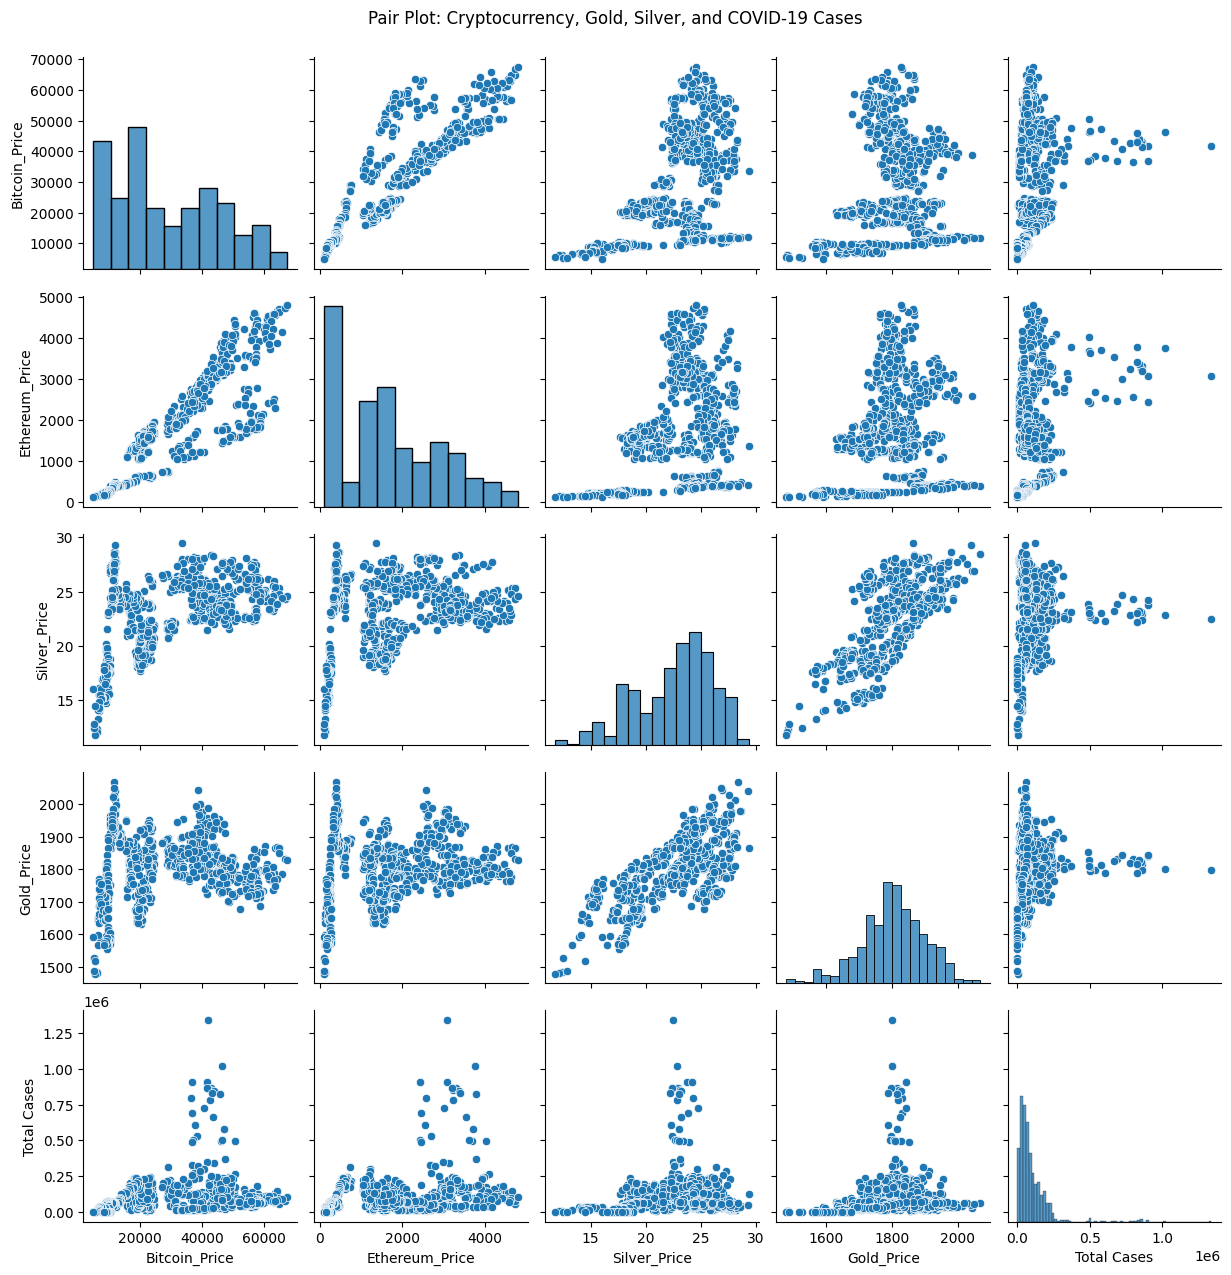

In [18]:
sns.pairplot(merged_df[selected_columns_q4], height=2.5) # creating the pair plot
plt.suptitle('Pair Plot: Cryptocurrency, Gold, Silver, and COVID-19 Cases', y=1.02) # setting the title
plt.show() # displaying the plot

In [19]:
merged_df[selected_columns_q4].describe() # displaying the descriptive statistics to observe bitcoin scale difference

,Bitcoin_Price,Ethereum_Price,Silver_Price,Gold_Price,Total Cases
count,772.000000,772.000000,772.000000,772.000000,7.720000e+02
mean,28859.483161,1710.741360,22.625060,1803.241321,1.056197e+05
std,16688.889051,1231.803409,3.489236,96.814425,1.344221e+05
min,4826.000000,107.900000,11.772000,1477.900000,0.000000e+00
25%,13561.025000,428.997500,20.046750,1741.675000,3.763375e+04
50%,23233.450000,1570.540000,23.365500,1806.100000,6.733000e+04
75%,42748.750000,2686.580000,25.231500,1867.700000,1.292972e+05
max,67527.900000,4808.380000,29.418000,2069.400000,1.340950e+06


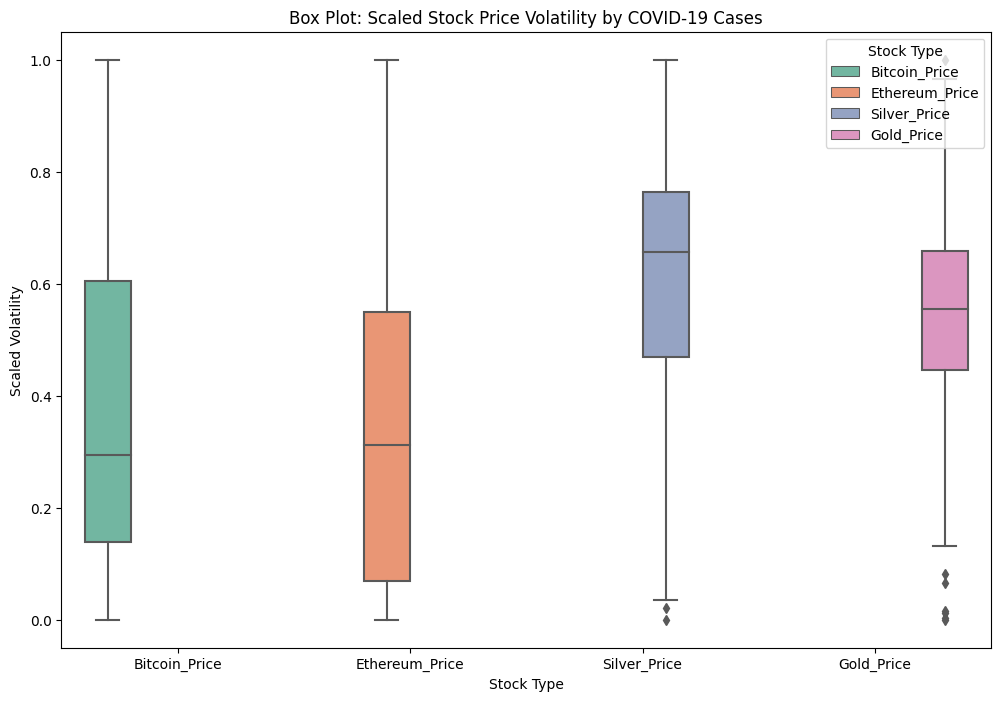

In [20]:
scaler = MinMaxScaler() # creating the min-max scaler
scaled_data = scaler.fit_transform(merged_df[selected_columns_q4]) # scaling the data

scaled_df = pd.DataFrame(scaled_data, columns=selected_columns_q4) # creating a new dataframe with the scaled data

melted_df = pd.melt(scaled_df, id_vars='Total Cases', var_name='Stock Type', value_name='Scaled Volatility') # melting the dataframe

plt.figure(figsize=(12, 8)) # creating a new figure
sns.boxplot(x='Stock Type', y='Scaled Volatility', data=melted_df, palette='Set2', hue='Stock Type') # creating the box plot
plt.title('Box Plot: Scaled Stock Price Volatility by COVID-19 Cases') # setting the title
plt.xlabel('Stock Type') # setting the x-axis label
plt.ylabel('Scaled Volatility') # setting the y-axis label
plt.legend(title='Stock Type', loc='upper right') # setting the legend location
plt.show() # displaying the plot

### Interpretation:
In these set of visualizations we try and understand the correlation and relationship between the number of covid cases and the stock prices of cryptocurrency like Bitcoin, Ethereum etc and valuable metals like Gold, Silver etc. The observations are as follows:
1. From the correlation heatmap we can first see that covid cases has a positive correlation with all types of stocks. This implies that the value of cryptocurrency and valuable metals went up as covid cases also peaked. Additionally, we can see that there are obvious groups forming as per the impact the number of covid cases has on the stock price. Gold and Silver are affected very similarly and the same can be seen in the case of Bitcoin and Ethereum. This is to be expected but having this heatmap confirm it supports our thinking regarding this research question. 
2. From the pair plot we can observe that there is no consistency in terms of what kind of distributions we are dealing with. Bitcoin and Ethereum seem to be somewhat right skewed whereas Silver seems left skewed and Gold deviates from this group forming pattern to have a normal distribution. Additionally our observations about correlation are confirmed in this plot with the help of the scatter plots between the covid cases and all the stock prices. 
3. From the min-max scaled box plot we can see that there may be statistically significant differences across the various types of stocks being considered in this particular question. The exact conclusion can be made during the inferential stage of this project by performing all sorts of regression analysis. Note that we had to scale our data due to Bitcoin having extremely different and large values which would have made the resultant box plot almost impossible to interpret and extract insights from.

# Inferential Analysis

## Question 1 - 
How did the stock prices of major tech companies (e.g., Apple, Amazon, Netflix, Meta) respond to significant peaks in daily confirmed COVID-19 cases? We aim to identify patterns in market movements during high infection rates and assess sector reactivity.

In [21]:
def fit_ols_model(data: pd.DataFrame, predictor_column: List[str], response_column: str) -> str:
    """
    Fit an Ordinary Least Squares (OLS) regression model using the provided data.

    Args:
        data: DataFrame containing the predictor and response variables.
        predictor_column: List of predictor column names.
        response_column: Name of the response column.

    Returns:
        Summary of the fitted OLS regression model.
    """
    X = sm.add_constant(data[predictor_column])  # Add constant term
    y = data[response_column] # Define the dependent variable
    model = sm.OLS(y, X).fit() # Fit the model
    return model.summary() # Return the model summary

predictor_columns = ['Total Cases']
response_variables = stockprice_to_sector_mapping['Tech']

for response_column in response_variables:
    ols_summary = fit_ols_model(merged_df, predictor_columns, response_column)
    print(f"-----Summary for OLS model with {predictor_columns} as predictor variables and {response_column} as response variable:-----")
    print(ols_summary)
    print("\n")

-----Summary for OLS model with ['Total Cases'] as predictor variables and Apple_Price as response variable:-----
                            OLS Regression Results                            
Dep. Variable:            Apple_Price   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     157.4
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           5.45e-33
Time:                        04:08:20   Log-Likelihood:                -3633.3
No. Observations:                 772   AIC:                             7271.
Df Residuals:                     770   BIC:                             7280.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------

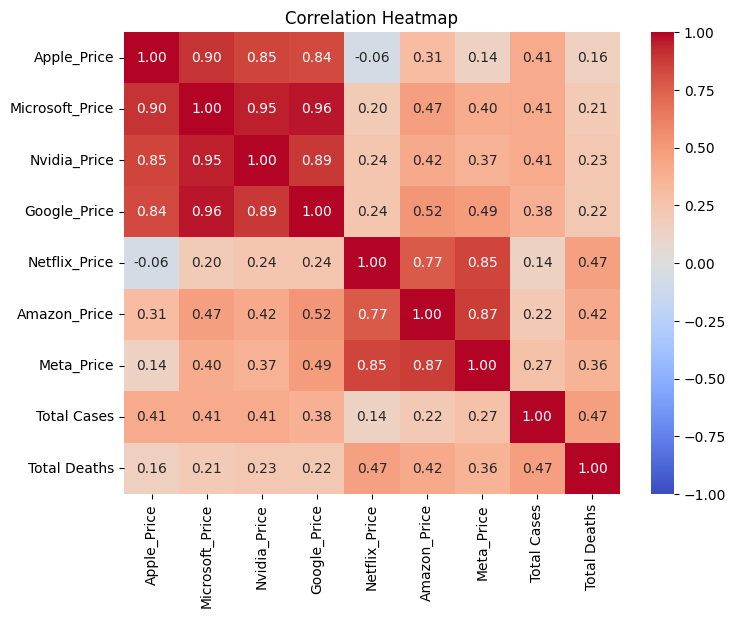

In [22]:
# Extract columns for correlation matrix
columns_to_include = stockprice_to_sector_mapping['Tech'] + ['Total Cases', 'Total Deaths']
corr_matrix = merged_df[columns_to_include].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

### Interpretation:

- OLS regression was performed to analyze the relationship between total COVID-19 cases/deaths and the stock prices of major tech companies.
- The R-squared values indicate the proportion of variance in stock prices explained by total COVID-19 cases is low to moderate, ranging from 0.02 to 0.17.
- The p-values (<0.05) for the coefficient of total cases in the regression models suggest a statistically significant relationship between total cases and stock prices for all companies except Netflix.
- The coefficients for total cases are positive, indicating that an increase in total cases is associated with higher stock prices, although the effect size varies between companies.
- Google's coefficient is relatively smaller compared to Microsoft, Nvidia, and Apple indicating its stock price is less sensitive to changes in total COVID-19 cases.
- Netflix has the smallest coefficient among the companies analyzed, at approximately 0.00004. This indicates that Netflix's stock price is the least affected by changes in total COVID-19 cases compared to the other companies examined.

From the correlation heatmap:
- Stock prices of Apple, Microsoft, Google, and Nvidia show very high positive correlations, suggesting that they may move together in response to similar market conditions.
- Meta has high positive correlations with Netflix and Amazon.
- Amazon and Netflix also exhibit high positive correlations, possibly due to their dominance in the e-commerce and streaming sectors.
- Total cases show a moderate-strong correlation (around 0.4) with the stock prices of Apple, Microsoft, Google, and Nvidia, and a weaker correlation (around 0.2) with Netflix, Amazon, and Meta.
- Conversely, total deaths show a moderate-strong correlation (around 0.4) with the stock prices of Netflix, Amazon, and Meta, and a weaker correlation (around 0.2) with Apple, Microsoft, Google, and Nvidia. This indicates that the number of deaths has a more pronounced impact on the stock prices of Netflix, Amazon, and Meta.

## Question 2 - 
Did fluctuations in economic indicators, such as the S&P 500 index, align with the severity of COVID-19 outbreaks, and were certain industries more resilient during the pandemic? We seek to the identify sectors that we more resilient.

In [23]:
sector_aggregate['Total Cases'] = merged_df['Total Cases']
sector_aggregate['Total Deaths'] = merged_df['Total Deaths']
predictor_columns = ['Total Cases']
response_variables = ['S&P_500_Price', 'Tech_Price', 'Fossil_Fuels_Price', 'Metals_Price', 'Cryptocurrency_Price', 'Transportation_Price']

for response_column in response_variables:
    ols_summary = fit_ols_model(sector_aggregate, predictor_columns, response_column)
    print(f"----- Summary for OLS model with {predictor_columns} as predictor variables and {response_column} as response variable: -----")
    print(ols_summary)
    print("\n")

----- Summary for OLS model with ['Total Cases'] as predictor variables and S&P_500_Price as response variable: -----
                            OLS Regression Results                            
Dep. Variable:          S&P_500_Price   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     135.3
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           6.31e-29
Time:                        04:08:21   Log-Likelihood:                -5884.9
No. Observations:                 772   AIC:                         1.177e+04
Df Residuals:                     770   BIC:                         1.178e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------

In [24]:
# Melt the sector_aggregate DataFrame to long format
melted = pd.melt(
    sector_aggregate,
    id_vars=['Date'],
    value_vars=['Tech_Price', 'Fossil_Fuels_Price', 'Metals_Price', 'Cryptocurrency_Price', 'Transportation_Price'],
    var_name='Sector',
    value_name='Stock_Price'
).drop(columns=['Date'])

# Remove '_Price' from the 'Sector' column values
melted['Sector'] = melted['Sector'].str.replace('_Price', '')

# Display the first few rows of the melted DataFrame
melted.head()

,Sector,Stock_Price
0,Tech,185.901429
1,Tech,190.472857
2,Tech,188.431429
3,Tech,190.292857
4,Tech,190.600000


In [25]:
# Fit the ANOVA model
model = ols('Stock_Price ~ C(Sector)', data=melted).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Sector),1.390899e+11,4.0,2195.903523,0.0
Residual,6.104453e+10,3855.0,NaN,NaN


### Interpretation:
- The OLS model for S&P 500 Index with Total Cases explains approximately 14.9% of the variance in the S&P 500 index based on changes in total COVID-19 cases, indicating a moderate association between COVID-19 cases and overall market sentiment reflected by the S&P 500 index.
- The technology sector demonstrates a stronger association with COVID-19 cases compared to other sectors, with a higher R-squared value (12.9%). The coefficients for other sectors such as fossil fuels, metals, cryptocurrency, and transportation are lower, suggesting weaker associations. This could be attributed to increased reliance on technology during the pandemic, leading to higher demand for tech products and services such as remote work solutions, e-commerce platforms, and digital entertainment.
- Sectors like metals and fossil fuels exhibit weaker associations in comparison to technology and cryptocurrency. This could be because sectors with higher levels of innovation and adaptability may exhibit greater resilience during times of uncertainty.
- The t-tests from OLS model confirm significant differences in mean prices between sectors based on total COVID-19 cases since the p-value for all sectors is less than the significance level of 0.05.
- The ANOVA model shows a significant effect of the sector on stock prices (p < 0.05), suggesting that different sectors have varying influences on stock prices.

## Question 3 - 
How did COVID-19 case counts in specific regions of the USA, for instance in the East and MidWest, affect the stock market the most? This question delves into regional variations in COVID-19 case counts and their corresponding impact. We aim to identify which regions exerted the most significant influence on market reactivity.

In [26]:
X = merged_df[['Northeast', 'Midwest', 'South', 'West']] # defining the independent variables
X = sm.add_constant(X) # adding a constant to the independent variables

y = merged_df['S&P_500_Price'] # defining the dependent variable
model_q3 = sm.OLS(y, X).fit() # fitting the model
print(model_q3.summary()) # printing the model summary

                            OLS Regression Results                            
Dep. Variable:          S&P_500_Price   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     38.12
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           4.10e-29
Time:                        04:08:21   Log-Likelihood:                -5877.4
No. Observations:                 772   AIC:                         1.176e+04
Df Residuals:                     767   BIC:                         1.179e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3704.2963     22.743    162.880      0.0

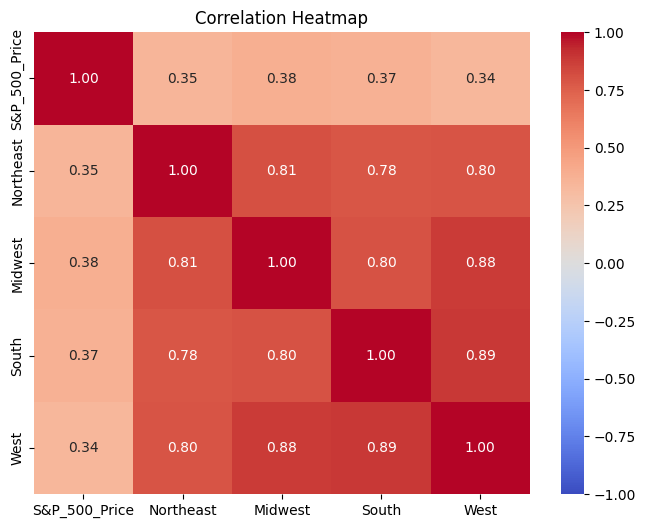

In [27]:
corr_matrix = merged_df[['S&P_500_Price', 'Northeast', 'Midwest', 'South', 'West']].corr() # creating the correlation matrix

plt.figure(figsize=(8, 6)) # creating a new figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1) # creating the heatmap
plt.title('Correlation Heatmap') # setting the title
plt.show() # displaying the plot

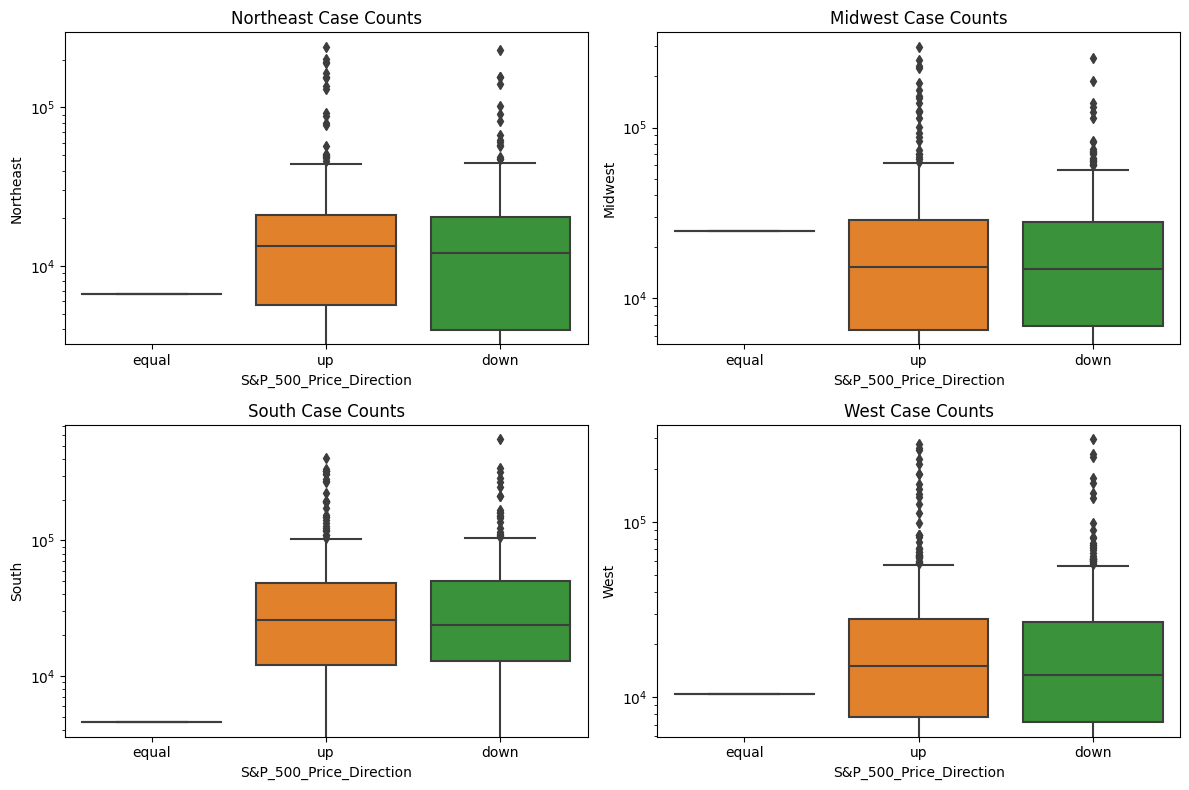

In [28]:
zones = ['Northeast', 'Midwest', 'South', 'West'] # defining the zones

fig, axs = plt.subplots(2, 2, figsize=(12, 8)) # creating a 2x2 grid of subplots

axs = axs.flatten() # flattening the 2x2 grid into a 1x4 grid for easier iteration

for i, zone in enumerate(zones): # iterating through the zones
    ax = axs[i] # getting the current axis
    sns.boxplot(x='S&P_500_Price_Direction', y=zone, data=merged_df, ax=ax) # creating the box plot
    ax.set_yscale('log') # setting the y-axis scale to logarithmic due to scale differences
    ax.set_title(f'{zone} Case Counts') # setting the title

plt.tight_layout() # tightening the layout
plt.show() # displaying the plot

In [29]:
tukey_results = [] # creating an empty list to store the Tukey's test results

# Iterate over each zone
for zone in zones:
    # Perform Tukey's test for the current zone
    tukey = pairwise_tukeyhsd(merged_df[zone], merged_df['S&P_500_Price_Direction'])
    
    # Append the results to the list
    tukey_results.append(tukey)

# Print the results for each zone
for i, zone in enumerate(zones):
    print(f"\n\n------------Tukey's HSD test results for {zone}:------------")
    print(tukey_results[i])



------------Tukey's HSD test results for Northeast:------------
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
  down  equal -9505.5285 0.9222 -67744.0068 48732.9497  False
  down     up  2793.4878 0.2619  -1400.4561  6987.4317  False
 equal     up 12299.0163 0.8733 -45946.3167 70544.3493  False
-------------------------------------------------------------


------------Tukey's HSD test results for Midwest:------------
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff p-adj     lower      upper    reject
------------------------------------------------------------
  down  equal 3612.0273 0.9921 -66972.0615 74196.1161  False
  down     up 4000.8507 0.1547  -1082.1411  9083.8425  False
 equal     up  388.8234 0.9999 -70203.5733 70981.2201  False
------------------------------------------------------------


-------

In [30]:
# Perform Tukey's test for the total cases and S&P 500 price direction
tukey_total_cases = pairwise_tukeyhsd(merged_df['Total Cases'], merged_df['S&P_500_Price_Direction'])

# Print the results
print("Tukey's HSD test results for Total Cases vs. S&P_500_Price_Direction:")
print(tukey_total_cases)

Tukey's HSD test results for Total Cases vs. S&P_500_Price_Direction:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------
  down  equal -52791.2457 0.9187 -368783.5508 263201.0595  False
  down     up  13975.3467 0.3198   -8780.2959  36730.9893  False
 equal     up  66766.5924 0.8732 -249262.9056 382796.0904  False
----------------------------------------------------------------


### Interpretation:
In this section we conducted some inferential analyses to examine the relationship between the number of cases in different zones in the United States and the stock market indicator S&P_500. Our observations are as follows:
1. From the OLS model summary we can see that nearly all zones have some relevance in the stock price. Assuming the level of significance to be 5% or 0.05 we see that all zones except Northeast seem to be relevant. From the coefficient values we can get a sense for the impact that each zone's cases seems to have on the stock market. We see that the Midwest zone has the highest positive impact whereas the West zone has the highest negative impact. These results must be taken with a grain of salt due to the fact that there may be certain multicollinearity issues present in the predictors.
2. We use the correlation heatmap to try and determine if collinearity issues exist within our predictors. The heatmap confirms that each zone seems to be significantly correlated with each other. These results are significant because it makes it difficult to assess individual impact and it also guides possible actions we can take during the machine learning stage. For example, dimensionality reduction might be an avenue to explore.
3. From the box-plots we can observe the distributions for days when the stock market rises and when it dips in relation to the value we observed on the day before. From the box-plot we observe that there may not be any statistically significant differences but the final conclusion can only be made from conducting some form of inferential analysis such as Tukey's HSD test.
4. From performing the Tukey's HSD test individually on each zone we see that there is no statistically significant difference between the stock market direction. We further extend this analysis by performing another HSD test on all covid cases across the United States and again observe that there was no difference in the cases across both stock market movements.

## Question 4 - 
Is there a correlation between cryptocurrency, gold and silver stock price volatility and daily confirmed COVID-19 cases?

In [31]:
predictor_column = 'Total Cases' # defining the predictor column
response_variables = ['Bitcoin_Price', 'Ethereum_Price', 'Gold_Price', 'Silver_Price'] # defining the response variables

for response_column in response_variables: # iterating through the response variables
    ols_summary = fit_ols_model(merged_df, predictor_column, response_column) # fitting the OLS model
    print(f"-----Summary for OLS model with {predictor_column} as predictor variable and {response_column} as response variable:-----")
    print(ols_summary) # printing the model summary
    print("\n")

-----Summary for OLS model with Total Cases as predictor variable and Bitcoin_Price as response variable:-----
                            OLS Regression Results                            
Dep. Variable:          Bitcoin_Price   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     52.43
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           1.08e-12
Time:                        04:08:24   Log-Likelihood:                -8575.3
No. Observations:                 772   AIC:                         1.715e+04
Df Residuals:                     770   BIC:                         1.716e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------

### Interpretation:
In this section we perform a inferential analysis on each of the stocks being considered in this research question. We observe that in the case of Bitcoin and Ethereum (cryptocurrency) the impact of the total cases is significant as can be seen from the beta coefficient. On the other hand the impact is insignificant when it comes to Gold and Silver stock prices as can be seen from a near zero coefficient value. This implies that there is very little to no correlation between covid cases count and Gold and Silver stock prices. This in conjunction with the visualization analysis we performed previously lets us make conclusions with respect to this research question.

# Comparitive Analysis

In [32]:
# Sort the merged_df DataFrame by 'Date' and reset the index
merged_df = merged_df.sort_values(by='Date').reset_index(drop=True)

# Sort the sector_aggregate DataFrame by 'Date' and reset the index
sector_aggregate = sector_aggregate.sort_values(by='Date').reset_index(drop=True)

In [33]:
# Calculate the difference in Total Cases between each day and the previous day
sector_aggregate['Cases_Diff'] = sector_aggregate['Total Cases'].diff()
sector_aggregate['Cases_Diff'] = sector_aggregate['Cases_Diff'].fillna(0)

# Function to classify each week as rise, stagnate, or fall
def classify_week(row):
    week_data = sector_aggregate[(sector_aggregate['Date'] >= row['Week_Start']) & (sector_aggregate['Date'] <= row['Week_End'])]
    rise_days = week_data[week_data['Cases_Diff'] > 0]['Cases_Diff'].count()
    if rise_days >= 4:
        return 'boom'
    elif rise_days >= 3:
        return 'stagnate'
    else:
        return 'fall'

# Get the start and end dates of each week
sector_aggregate['Week_Start'] = sector_aggregate['Date'] - pd.to_timedelta(sector_aggregate['Date'].dt.weekday, unit='D')
sector_aggregate['Week_End'] = sector_aggregate['Week_Start'] + pd.DateOffset(days=6)

# Classify each week as rise, stagnate, or fall
sector_aggregate['Week_Trend'] = sector_aggregate.apply(classify_week, axis=1)

# Drop unnecessary columns
sector_aggregate.drop(columns=['Cases_Diff', 'Week_Start', 'Week_End'], inplace=True)

# Display the counts of each week trend category
sector_aggregate['Week_Trend'].value_counts()

Week_Trend
fall        380
stagnate    272
boom        120
Name: count, dtype: int64

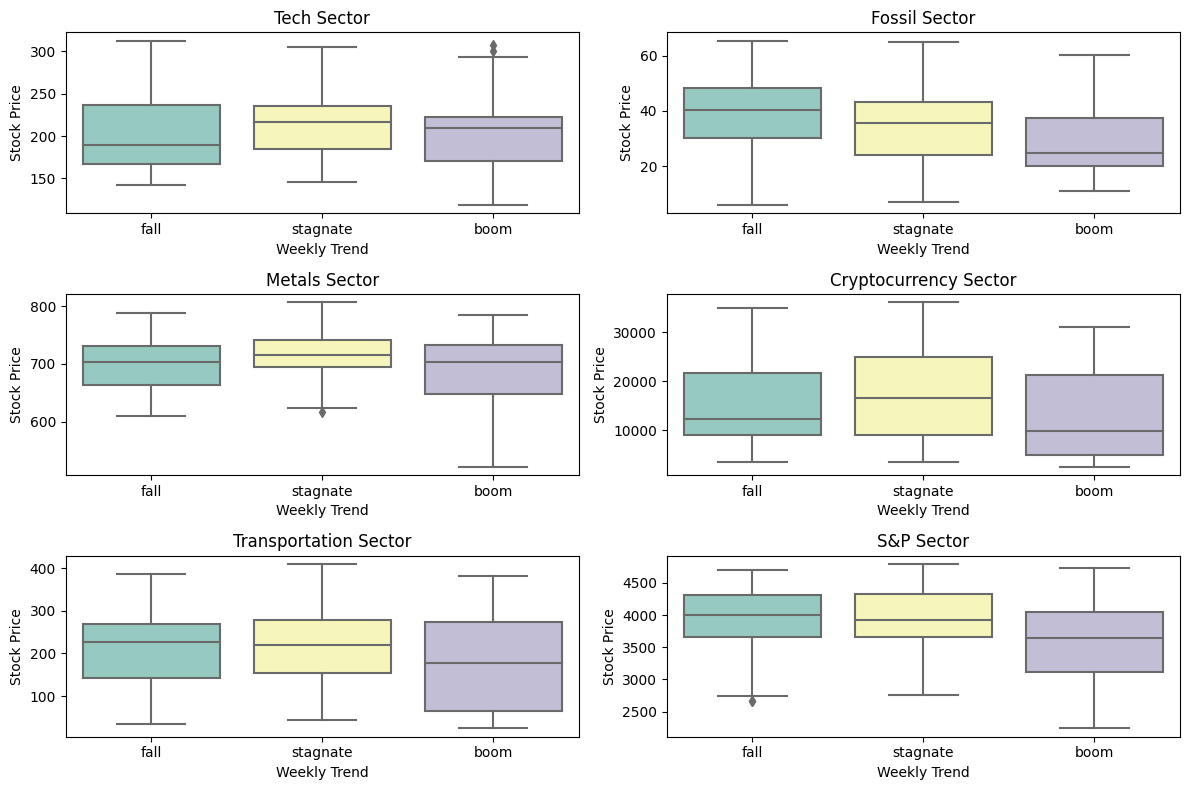

In [34]:
# Define the sectors to plot
sectors_to_plot = ['Tech_Price', 'Fossil_Fuels_Price', 'Metals_Price', 'Cryptocurrency_Price', 'Transportation_Price', 'S&P_500_Price']

# Define order of weekly trend categories
weekly_trend_order = ['fall', 'stagnate', 'boom']

# Create subplots for the subplot grid
fig, axes = plt.subplots(nrows=(len(sectors_to_plot) + 1) // 2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each sector
for i, sector in enumerate(sectors_to_plot):
    # Create a DataFrame for the sector's stock prices and weekly trends
    sector_data = sector_aggregate[['Week_Trend', sector]]
    
    # Melt the DataFrame to long format for plotting
    sector_data_melted = sector_data.melt(id_vars='Week_Trend', value_vars=[sector], var_name='Sector')
    
    # Plot the boxplot for the sector
    sns.boxplot(data=sector_data_melted, x='Week_Trend', y='value', ax=axes[i], palette='Set3', order=weekly_trend_order)
    
    # Set plot title and labels
    axes[i].set_title(f'{sector.split("_")[0]} Sector')
    axes[i].set_ylabel('Stock Price')
    axes[i].set_xlabel('Weekly Trend')
    axes[i].legend().remove()  # Remove legend

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Interpretation:

In this section we compare and contrast the market performance of the various sectors during periods of dips, peaks, and stagnation in the total covid cases in the United States with the help of box plots. We segmented our data into these periods by tracking the number of covid cases over a period of 7 days at the end of which we can determine if the covid cases count is currently in a boom, fall or stagnation period. Our observations were as follows:
1.	In the tech sector there seems to be differences in the three boxplots with the fall plot being the most different out of the three. The stagnate and boom plots look very similar with the obvious difference of the boom period having some outliers which results in it becoming skewed. 
2.	The fossil fuels sector has a clear pattern emerging from this segmentation. The stock price seems to drop as covid cases start increasing and moving towards a boom. This is in line with what we would expect and it also confirms the patterns we have observed with respect to this sector.
3.	The metals sector is very interesting in the sense that the fall and boom boxplots seem to behave very similarly but the plot during the stagnation period shows a heavy concentration at higher stock prices. This may allude to the way in which people view investing in precious metals. It seems like the people invest more in this sector during stagnation periods that are relatively safer and uneventful. 
4.	The cryptocurrency sector boxplots are very similar to the ones from the metals sector with obvious differences in the overall higher stock price in general and more spread out concentration during the stagnation period. It is important to note here that the boxplots indicate a skewed distribution which is line with what we would expect from cryptocurrency trading which is somewhat impacted by public and social sentiment towards it.
5.	The transportation sector boxplots indicate similar market sentiment towards these companies during the safer periods of fall and stagnate. This indicates that the transportation sector is generally viewed as less of a safe bet during volatile periods. This is in line with what we expected based on the transportation restrictions that were put into place during the peak periods of the pandemic.

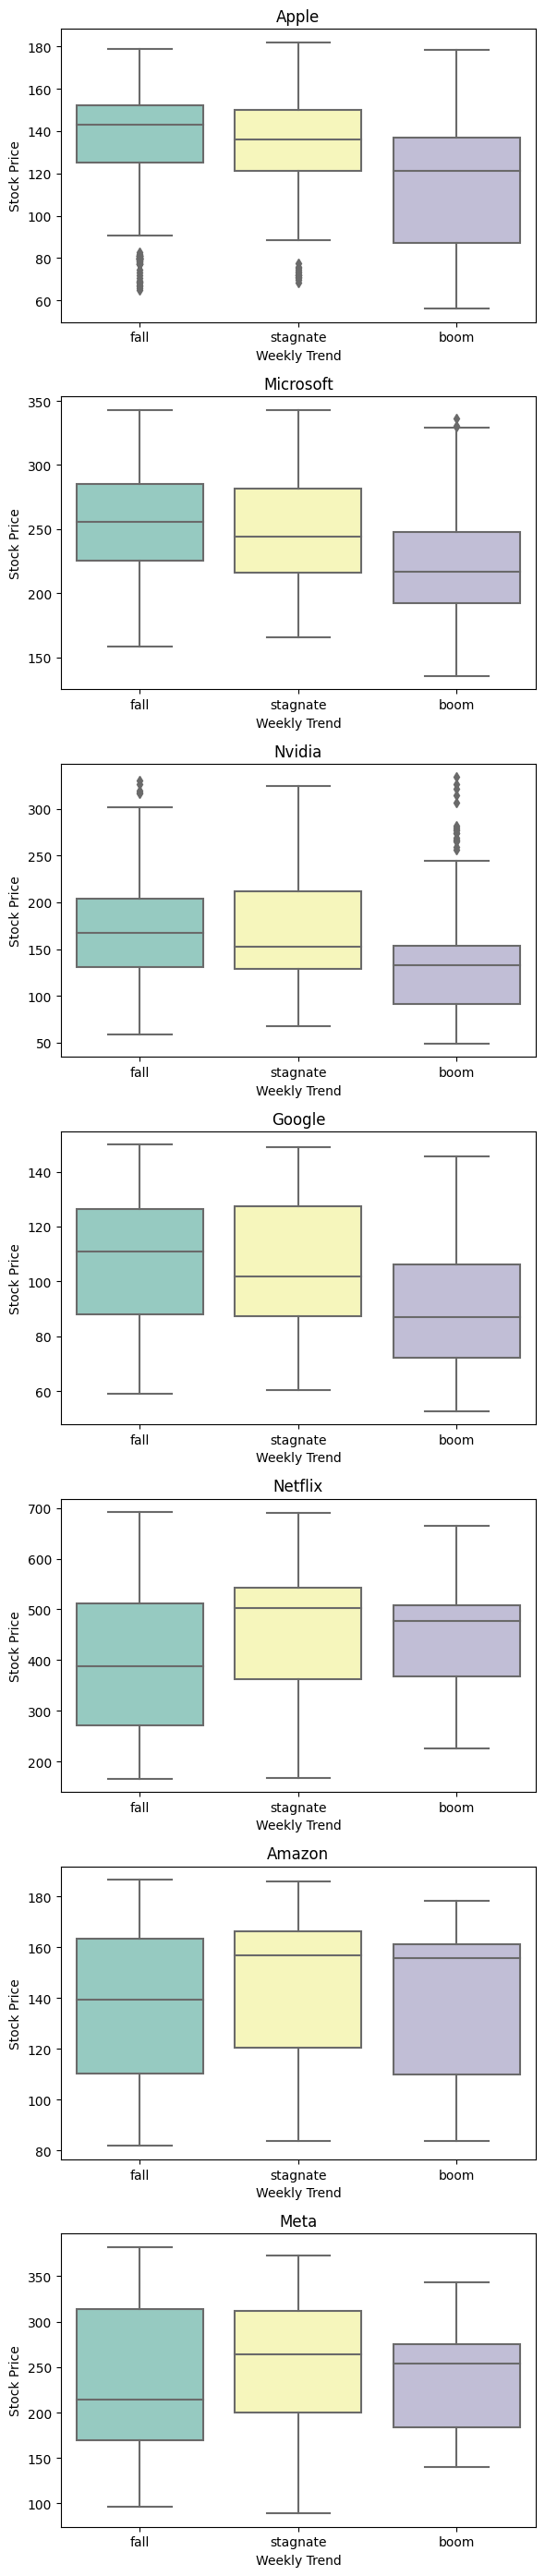

In [35]:
# Assign 'Week_Trend' column from sector_aggregate to merged_df
merged_df['Week_Trend'] = sector_aggregate['Week_Trend']

# Define the companies to plot within the 'Tech' sector
companies_to_plot = stockprice_to_sector_mapping['Tech']

# Create subplots for the subplot grid
fig, axes = plt.subplots(nrows=len(companies_to_plot), ncols=1, figsize=(6, 4 * len(companies_to_plot)))

# Iterate over each company
for i, company in enumerate(companies_to_plot):
    # Create a DataFrame for the company's stock prices and weekly trends
    company_data = merged_df[['Week_Trend', company]]
    
    # Melt the DataFrame to long format for plotting
    company_data_melted = company_data.melt(id_vars='Week_Trend', value_vars=[company], var_name='Company')
    
    # Plot the box plot for the company
    sns.boxplot(data=company_data_melted, x='Week_Trend', y='value', ax=axes[i], palette='Set3', order=weekly_trend_order)
    
    # Set plot title and labels
    axes[i].set_title(f'{company.split("_")[0]}')
    axes[i].set_ylabel('Stock Price')
    axes[i].set_xlabel('Weekly Trend')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Interpretation:  
In this section we take our previous analysis a step further and dive deeper into the tech domain which showed no clear pattern in many of our previous analyses. We once again utilize box plots for this purpose and our observations are as follows:
1.	For the company Apple, there is a very clear pattern that emerges from this analysis. We notice that as we the nation moves towards higher segments of covid cases, the stock price drops. This is in line with what we would expect.
2.	For the companies Microsoft, Nvidia, and Google, we see trends that are very similar to what we observed in the case of Apple with some small differences in the exact shape of the distribution and presence of outliers.
3.	For the company Netflix, we observe the first deviation from the previously observed trends. There does not seem to be a direct increasing or decreasing trend like what we saw with Apple. It seems like Netflix performs well during the stagnation and boom periods of the pandemic which is in line with what we would expect to see from a company that saw a greater usage during the time when people could not move outside from their homes considering the restrictions put into place due to the rising covid cases.
4.	For the companies, Amazon, and Meta, we see trends that are very similar to what we observed in the case of Netflix with some small differences in the exact shape of the distribution. 
5.	This mixed pattern in which different companies reacted to the pandemic, explains our findings in the previous sections where we could not observe any significant obvious trends for the tech sector in general.

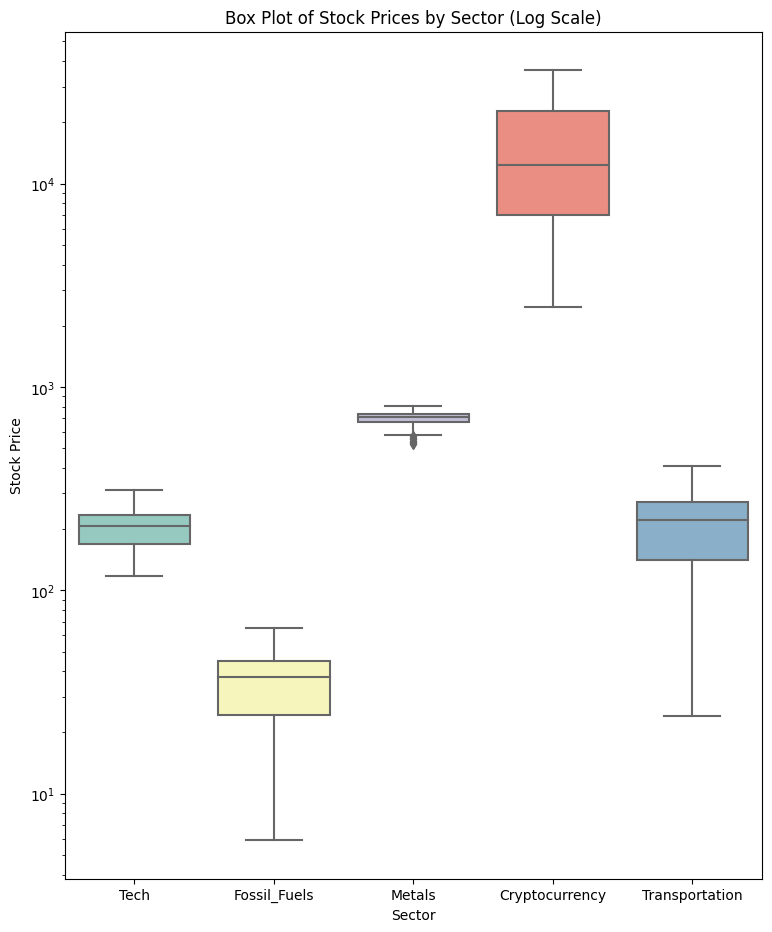

In [36]:
# Create a box plot of stock prices, take log on y-axis for better visualization
plt.figure(figsize=(9, 11))

# Plot the box plot
sns.boxplot(data=melted, x='Sector', y='Stock_Price', palette='Set3')

# Set labels and title
plt.xlabel('Sector')
plt.yscale('log')  # Apply logarithmic scale on y-axis
plt.ylabel('Stock Price')
plt.title('Box Plot of Stock Prices by Sector (Log Scale)')

# Display the plot
plt.show()

In [37]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(melted['Stock_Price'], melted['Sector'])
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Cryptocurrency,Fossil_Fuels,-15249.0983,0.0,-15801.852,-14696.3446,True
Cryptocurrency,Metals,-14581.9004,0.0,-15134.6541,-14029.1467,True
Cryptocurrency,Tech,-15077.3151,0.0,-15630.0688,-14524.5614,True
Cryptocurrency,Transportation,-15078.243,0.0,-15630.9967,-14525.4893,True
Fossil_Fuels,Metals,667.1979,0.0088,114.4442,1219.9516,True
Fossil_Fuels,Tech,171.7833,0.9154,-380.9704,724.537,False
Fossil_Fuels,Transportation,170.8553,0.917,-381.8984,723.609,False
Metals,Tech,-495.4146,0.1035,-1048.1683,57.3391,False
Metals,Transportation,-496.3426,0.1024,-1049.0963,56.4111,False
Tech,Transportation,-0.9279,1.0,-553.6816,551.8258,False


### Interpretation:

- There are statistically significant differences in mean stock prices between Cryptocurrency and each of the other sectors (Fossil Fuels, Metals, Tech, and Transportation). The mean stock price for Cryptocurrency is significantly higher than that of Fossil Fuels, Metals, Tech, and Transportation.
- There is a statistically significant difference in mean stock prices between Fossil Fuels and Metals. The mean stock price for Fossil Fuels is significantly lower than that of Metals.
- There are no statistically significant differences in mean stock prices between Fossil Fuels and either Tech or Transportation.
- The mean stock prices for Metals are not significantly different from those of Tech or Transportation.
- There are no statistically significant differences in mean stock prices between Tech and Transportation. The mean stock prices for Tech and Transportation are not significantly different.

In [38]:
# extracting the total cases for the up, down, and equal S&P 500 price directions

up_cases = merged_df[merged_df['S&P_500_Price_Direction'] == 'up']['Total Cases']
down_cases = merged_df[merged_df['S&P_500_Price_Direction'] == 'down']['Total Cases']
equal_cases = merged_df[merged_df['S&P_500_Price_Direction'] == 'equal']['Total Cases']

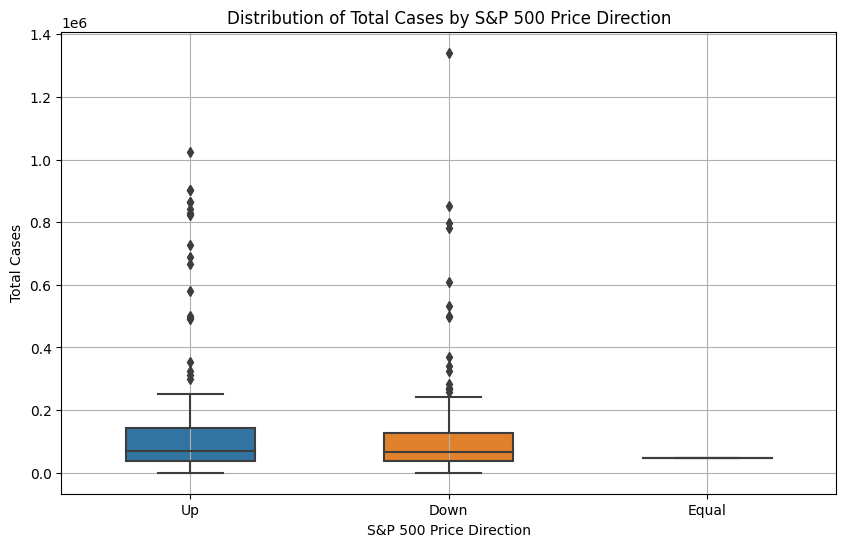

In [39]:
plt.figure(figsize=(10, 6)) # creating a new figure
sns.boxplot(data=[up_cases, down_cases, equal_cases], width=0.5) # creating the box plot
plt.xticks(ticks=[0, 1, 2], labels=['Up', 'Down', 'Equal']) # setting the x-axis ticks and labels
plt.xlabel('S&P 500 Price Direction') # setting the x-axis label
plt.ylabel('Total Cases') # setting the y-axis label
plt.title('Distribution of Total Cases by S&P 500 Price Direction') # setting the title
plt.grid(True) # enabling the grid
plt.show() # displaying the plot

In [40]:
all_cases = pd.concat([up_cases, down_cases, equal_cases]) # concatenating the total cases
labels = ['Up'] * len(up_cases) + ['Down'] * len(down_cases) + ['Equal'] * len(equal_cases) # creating the labels

tukey_results = pairwise_tukeyhsd(all_cases, labels, 0.05) # performing Tukey's HSD test
print("\nTukey's HSD Test Results:") # printing the results
print(tukey_results) # printing the results


Tukey's HSD Test Results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------
  Down  Equal -52791.2457 0.9187 -368783.5508 263201.0595  False
  Down     Up  13975.3467 0.3198   -8780.2959  36730.9893  False
 Equal     Up  66766.5924 0.8732 -249262.9056 382796.0904  False
----------------------------------------------------------------


### Interpretation:
The comparative analysis between COVID-19 case counts and movements in the S&P 500 price direction revealed no statistically significant differences in case counts across different market movements (up, down, or equal), as evidenced by both boxplots and Tukey's HSD test. This outcome suggests that short-term fluctuations in the stock market, particularly as measured by daily comparisons of the S&P 500 price direction, do not appear to have a discernible impact by the spread of COVID-19. Several factors may contribute to this finding, including the high volatility inherent in the stock market, the high-frequency nature of daily market movements, and the complex interplay of various economic, political, and public health factors influencing both the stock market and the trajectory of the pandemic. Further investigation incorporating additional variables and longer time frames may provide deeper insights into the relationship between financial market dynamics and public health outcomes during crises such as the COVID-19 pandemic.

# Multivariate Analysis

In [41]:
merged_df['Total Cases'].describe() # displaying the descriptive statistics for the total cases
# helps to decide how to segment the cases

count    7.720000e+02
mean     1.056197e+05
std      1.344221e+05
min      0.000000e+00
25%      3.763375e+04
50%      6.733000e+04
75%      1.292972e+05
max      1.340950e+06
Name: Total Cases, dtype: float64

In [42]:
def create_total_cases_segments(df) -> pd.DataFrame:
    """This function creates segments for the total cases based on quartiles."""
    quartiles = df['Total Cases'].quantile([0, 0.25, 0.5, 0.75, 1]).values # getting the quartiles
    labels = ['Q1', 'Q2', 'Q3', 'Q4'] # defining the labels
    df['Total Cases Segment'] = pd.cut(df['Total Cases'], bins=quartiles, labels=labels, include_lowest=True) # creating the segments
    return df # returning the dataframe

def create_pivot_table(df, values_column) -> pd.DataFrame:
    """This function creates a pivot table for the given dataframe and values column."""
    df = create_total_cases_segments(df) # creating the total cases segments
    # creating the pivot table
    pivot_table = df.pivot_table(values=values_column, index='Total Cases Segment', \
                                columns='S&P_500_Price_Direction', aggfunc='mean', observed=False)
    return pivot_table # returning the pivot table

In [43]:
def generate_sector_pivot_tables(df, stock_to_sector_mapping) -> dict:
    """This function generates pivot tables for the sectors."""
    pivot_tables = {} # creating an empty dictionary to store the pivot tables
    for sector, stocks in stock_to_sector_mapping.items(): # iterating through the stock to sector mapping
        df[sector + '_Volume'] = df[stocks].sum(axis=1) # aggregating the sector data
        
        pivot_table = create_pivot_table(df, sector + '_Volume') # creating the pivot table
        pivot_tables[sector] = pivot_table # storing the pivot table in the dictionary
        
        df.drop(columns=[sector + '_Volume'], inplace=True) # dropping the aggregated sector data
    
    return pivot_tables # returning the pivot tables

## Sector Wise Pivot Tables

In [44]:
# creating the pivot tables for the sectors
sector_pivot_tables = generate_sector_pivot_tables(merged_df, stock_to_sector_mapping)

In [45]:
# printing the pivot tables

for sector in stock_to_sector_mapping.keys():
    print(f'\n\n--------------------Pivot Table for {sector}:--------------------')
    print(sector_pivot_tables[sector])



--------------------Pivot Table for Tech:--------------------
S&P_500_Price_Direction          down        equal            up
Total Cases Segment                                             
Q1                       3.901012e+08          NaN  3.918979e+08
Q2                       3.508970e+08  247850000.0  3.464559e+08
Q3                       3.086531e+08          NaN  3.120905e+08
Q4                       3.027541e+08          NaN  2.973839e+08


--------------------Pivot Table for Fossil_Fuels:--------------------
S&P_500_Price_Direction           down     equal             up
Total Cases Segment                                            
Q1                       617163.724457       NaN  622225.147648
Q2                       438183.114837  488110.0  429769.405483
Q3                       493126.159979       NaN  441793.364691
Q4                       454890.397830       NaN  464069.924104


--------------------Pivot Table for Metals:--------------------
S&P_500_Price_Direction 

### Interpretation:
1. Despite the fluctuation in trading volume across different quartiles of total COVID-19 cases, there is no clear pattern indicating a direct impact of increasing cases on trading activity within the Tech sector alluding to its resillience. However, notably, when the S&P 500 price is up, there is a noticeable increase in trading volume across most quartiles, suggesting that positive market movements may override the influence of increasing COVID-19 cases.
2. Similar to the Tech sector, the Fossil Fuels sector shows variability in trading volume across quartiles of total cases, with no discernible trend related to increasing COVID-19 cases. However, there is a slight increase in trading volume when the S&P 500 price is up, indicating a potential positive correlation between market sentiment and trading activity in this sector.
3. Trading volume in the Metals sector also lacks a clear pattern in response to increasing COVID-19 cases. While there is a slight decrease in volume when the S&P 500 price is up in higher quartiles, the overall impact of increasing cases on trading activity within this sector appears minimal.
4. In contrast, the Cryptocurrency sector demonstrates a significant increase in trading volume when the S&P 500 price is up, despite the rising trend in COVID-19 cases. This suggests that positive market movements exert a substantial influence on trading activity within the Cryptocurrency sector, overshadowing the impact of increasing cases. This speaks to not only this sector being extremely resillient, but also thriving in the face of a worsening pandemic.
5. Similarly, the Transportation sector exhibits a pronounced increase in trading volume when the S&P 500 price is up, regardless of the rising number of COVID-19 cases. This pattern underscores the strong correlation between positive market movements and heightened trading activity within the Transportation sector, despite the ongoing pandemic challenges.

## Pivot Tables for Tech Companies

In [46]:
# creating and printing the pivot table for the tech companies

for company in stock_to_sector_mapping['Tech']:
    company_pivot_table = create_pivot_table(merged_df, company)
    print(f'\n\n--------------------Pivot Table for {company[:-4]}:--------------------')
    print(company_pivot_table)



--------------------Pivot Table for Apple:--------------------
S&P_500_Price_Direction          down       equal            up
Total Cases Segment                                            
Q1                       1.399913e+08         NaN  1.387052e+08
Q2                       1.166441e+08  53450000.0  1.131670e+08
Q3                       9.204149e+07         NaN  8.949793e+07
Q4                       9.395372e+07         NaN  9.216424e+07


--------------------Pivot Table for Microsoft:--------------------
S&P_500_Price_Direction          down       equal            up
Total Cases Segment                                            
Q1                       3.668667e+07         NaN  3.890824e+07
Q2                       3.115642e+07  26480000.0  3.122826e+07
Q3                       2.860366e+07         NaN  2.872793e+07
Q4                       2.869798e+07         NaN  3.040485e+07


--------------------Pivot Table for Nvidia:--------------------
S&P_500_Price_Direction         

### Interpretation:
1. Apple's trading volume tends to be higher when the S&P 500 price is down, indicating increased trading activity during market downturns. This suggests that investors may perceive Apple as a relatively safer investment during periods of market volatility.
2. Microsoft exhibits higher trading volume when the S&P 500 price is up, implying heightened investor interest and activity during positive market movements. This may reflect confidence in Microsoft's resilience and growth potential, particularly in buoyant market conditions.
3. Nvidia's trading volume shows mixed effects across different S&P 500 price movements, with no clear pattern emerging. This variability suggests that Nvidia's trading activity may be influenced by factors beyond broad market and pandemic trends.
4. Google's trading volume appears to be higher when the S&P 500 price is down, indicating increased activity during market declines. This pattern may reflect investor behavior seeking refuge in established tech giants like Google during periods of market uncertainty.
5. Netflix exhibits higher trading volume when the S&P 500 price is up, suggesting increased investor interest and activity during positive market movements. This could be attributed to the perception of Netflix as a beneficiary of stay-at-home trends and entertainment consumption during economic recoveries.
6. Amazon's trading volume tends to be higher when the S&P 500 price is down, implying heightened activity during market downturns. This pattern aligns with Amazon's reputation as a resilient and dominant player in e-commerce, attracting investor attention during times of market turbulence.
7. Meta's trading volume shows mixed effects across different S&P 500 price movements, with no clear pattern discernible. This variability suggests that Meta's trading activity may be influenced by a combination of factors beyond market trends, such as regulatory concerns or company-specific developments.
8. It is interesting to note here that the mixture of trends seen in the Tech sector companies, explains the mixed patterns we observed in the sector wise pivot tables. This alludes to the Tech domain being heavily diverse in the ways in which different companies reacted during the pandemic.

# Synthesis

### Question 1:
The combination of datasets allowed for a comprehensive analysis of how major tech companies responded to COVID-19 outbreaks. The analysis unveiled that while there is a general association between COVID-19 cases and stock prices in the tech sector, the magnitude and direction of this association vary across companies. Companies offering digital services experienced higher volatility in stock prices during the pandemic, reflecting changing consumer behaviors. Through OLS regression, a statistically significant link emerged between total COVID-19 cases and stock prices across major tech firms. Despite variations among companies, the positive coefficients implied a general trend where increasing COVID-19 cases correlated with higher stock prices.

### Question 2:
The combination of datasets facilitated the identification of sector-specific trends and patterns that would not have been apparent with individual datasets alone. The findings suggest that certain sectors, such as technology and transportation, exhibited a higher impact from the COVID-19 pandemic, while others, like cryptocurrencies and metals, were less impacted. Box plots and ANOVA tests provided insights into how different sectors responded to fluctuations in COVID-19 cases. Further research could explore additional variables and longer time frames to enhance understanding of sector resilience.

### Question 3:
Based on the analyses we performed in the previous sections we can comment on which regions in the United States had the highest impact on the stock market. We observed that the Midwest zone has the highest positive impact whereas the West zone has the highest negative impact. It is important to note that while the current analyses indicate that all zones had some levels of significance, the inferential analysis in particular must be taken with a grain of salt due to the fact that there may be certain multicollinearity issues present in the predictors. In conclusion, all regions had some form of varying impact on the market but the Midwest and the West zones had the highest positive and negative impact respectively. In future analysis, we could potentially try to determine why this is the case but that will require more specialized data and domain knowledge.

### Question 4:
Based on the analyses we performed in the previous sections we can conclude that there most definitely exists a correlation between cryptocurrency, gold and silver stock price volatility and daily confirmed COVID-19 cases. Delving into this conclusion further we can also comment on a few patterns observed throughout the analyses. First, we see that covid cases has a positive correlation with all types of stocks. This implies that the value of cryptocurrency and valuable metals went up as covid cases also peaked. Second, we see that there are obvious groups forming as per the impact the number of covid cases has on the stock price. Gold and Silver are affected very similarly and the same can be seen in the case of Bitcoin and Ethereum. Third, from the OLS model summaries we observe that in the case of Bitcoin and Ethereum (cryptocurrency) the impact of the total cases is significantly higher as can be seen from the beta coefficients. On the other hand, the impact is much lower when it comes to Gold and Silver stock prices as can be seen from a near zero coefficient value. This implies that there is very weak correlation between daily confirmed COVID-19 cases and gold and silver stock prices. These conclusions lead us to believe that cryptocurrency is considered to be an attractive investment option during the tumulus times of market uncertainty due to their growth potential. On the other hand, valuable metals like Gold and Silver are safer investment options that have been shown to be sufficiently resilient to the effects of the pandemic.

# Reflection

The data analysis process involved several challenges and strategies for addressing them. 

- In the inferential analysis, performing multivariate regression with multiple response variables and a single predictor variable presented challenges. Despite these challenges, iterative application of OLS regression enabled a thorough examination of each sector's response to the pandemic. However, OLS regression assumes linear relationships between variables, potentially overlooking complex interactions or nonlinear associations present in the data. Additionally, the analysis could not isolate the effect of deaths from total COVID-19 cases due to multicollinearity issues in OLS. Future research could explore more sophisticated statistical techniques, such as time-series analysis to capture dynamic interactions and causal relationships. Our analysis may overlook nuances between companies that could affect their resilience during the pandemic.
- The comparative analysis involved segmenting the data into weekly trends based on COVID-19 case differences. Establishing a robust method for classifying weekly trends as "boom," "stagnate," or "fall" posed a challenge due to the complex nature of fluctuations and the need for a standardized approach. We developed a function to classify weeks based on the majority vote of daily case trends over a week to systematically create subsets. Our analysis relies on daily stock price data aggregated into weekly trends, potentially overlooking intra-week fluctuations that may impact sector performance. 

- Dealing with highly volatile data like that of stock prices, trading volumes, and covid cases makes it difficult to develop cleaner visualizations which in turn results in increasing the difficulty to extract long term insights. This obstacle and its subsequent analysis helped us understand approaches we can utilize to make the visualizations and other analyses easier to analyze and represent. In our case, we used rolling windows of 7 days to introduce a little smoothness into our analyses without losing too much information. This resulted in much better visualizations that were still capable of capturing the important trends which are what matter to our overall research goals of this project. 

- Another obstacle we faced was with respect to data being on scales that are very different from one another. This was not a common problem where we could simply scale the variables independently due to the difference in scale actually being meaningful. This put us at a crossroads where we were not able to obtain interpretable visualizations and analyses without losing the information with scaling. Currently we make our best attempt at scaling and still maintaining some form of statistical meaning to the analyses but this is some research that could help us make better analyses and interpretations from the data without losing any information due to scaling.

- In order to obtain pivot tables that are both informative but easy to digest, we had to find a way to introduce the number of covid cases as a categorical variable. In our case we segmented the originally numeric column as per its quartiles to obtain categories which retain statistical meaning and significance but make it easier to incorporate into a pivot table. Having it be categorical instead of numeric allowed us to make tables which are easy to interpret and have meaning with respect to the overall trends that we are trying to ascertain.

Overall, this phase of the project really helped us to become better at manipulating data, developing hypotheses, and designing, implementing, and interpreting these analyses to extract meaningful insights that can help make conclusions and decisions with respect to the research questions.